# Conditional variational autoencoder (using the VAE class)

# SETUP

In [1]:
!python --version


Python 3.6.7


In [2]:
%%bash
git clone https://github.com/masa-su/pixyz.git

fatal: destination path 'pixyz' already exists and is not an empty directory.


In [3]:
!apt-get update && apt-get install ffmpeg

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.4-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.


In [4]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
!pip install tensorboardX
!pip install -e pixyz --process-dependency-links
torch.cuda.is_available()

Obtaining file:///content/pixyz
DEPRECATION: Dependency Links processing has been deprecated and will be removed in a future release. A possible replacement is PEP 508 URL dependencies. You can find discussion regarding this at https://github.com/pypa/pip/issues/4187.
  Found existing installation: pixyz 0.0.2
    Can't uninstall 'pixyz'. No files were found to uninstall.
  Running setup.py develop for pixyz


True

# CVAE

generative process

2dimention data

c=f(ut,s(t-1))

st~p(st|ut, s(t-1))=N(c , sigma)

ot~p(ot|st)=N(st,sigma)

それぞれの分散共分散行列には対角行列を使用（制御がめんどそうだから

In [27]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter
import numpy as np

from tqdm import tqdm

batch_size = 128
epochs =200#10
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [28]:
root = '../data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda o: o.view(-1))])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root=root, train=True, transform=transform, download=True),
#     shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root=root, train=False, transform=transform),
#     shuffle=False, **kwargs)

In [29]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE

In [30]:
#function for generate data
import torch.distributions as dist

def origin_datagenerator(sample_num,dsigma,axis):
  ca_axis=[-3,-2]
  cb_axis=[3,3]
  cc_axis=[7,5]
  
  data_cso={}
  
  ones=torch.ones(int(sample_num/3))
  
  sample_ca = torch.stack([ones*axis[0][0],ones*axis[0][1]],1)
  sample_cb = torch.stack([ones*axis[1][0],ones*axis[1][1]],1)
  sample_cc = torch.stack([ones*axis[2][0],ones*axis[2][1]],1)
  data_cso.update({"c":torch.cat([sample_ca,sample_cb,sample_cc],dim=0)})
  data_cso.update({"s":dist.Normal(data_cso["c"],dsigma).sample()})
  data_cso.update({"o":dist.Normal(data_cso["s"],dsigma).sample()})
#   data_cso.update([ ("c",torch.cat([sample_ca,sample_cb,sample_cc],dim=0)), ("s",dist.Normal(data_cso["c"],dsigma).sample()) ])
  
  return data_cso
  
#
def unique_datagenerator(sample_num,dsigma,u_fragx,u_fragy):
    data_cso={}
    
    #st-1
    sample_sx=torch.rand(sample_num)*200-100#-100~100の範囲で一様分布#一旦0~100
    sample_sy=torch.rand(sample_num)*200-100
    st1=torch.cat([sample_sx.view(sample_num,1),sample_sy.view(sample_num,1)],dim=1)
    print(st1)
    
    if u_fragx == 0.0 and u_fragy ==0.0:
        #ut
        sample_ux=torch.rand(sample_num)*20-10#移動距離は-10~10
        sample_uy=torch.rand(sample_num)*20-10
        ut=torch.cat([sample_ux.view(sample_num,1),sample_uy.view(sample_num,1)],dim=1)
        print(ut)
    else:
        sample_ux=torch.ones(sample_num)*u_fragx#移動距離は-10~10
        sample_uy=torch.ones(sample_num)*u_fragy
        ut=torch.cat([sample_ux.view(sample_num,1),sample_uy.view(sample_num,1)],dim=1)
        print(ut)
        
    #その他
    sample_c=st1+ut
    ut=ut*10

    print(sample_c)
    data_cso.update({"st1":st1})#t-1時刻の位置
    data_cso.update({"u":ut})#制御
    data_cso.update({"c":sample_c})#動作モデルを通したs(分散なし)
    data_cso.update({"s":dist.Normal(data_cso["c"],dsigma).sample()})#真の位置(分散を通している)
    data_cso.update({"o":dist.Normal(data_cso["s"],dsigma).sample()})#計測値（stと同じ位置だが，分散が載っている

    return data_cso

In [31]:
sample_num=3000
ssigma=torch.Tensor([0.5,0.5]*sample_num).view(sample_num,2)#状態遷移時の分散
osigma=torch.Tensor([0.5,0.5]*sample_num).view(sample_num,2)#計測情報の分散

axis=[[-3,-2],[3,3],[7,5]]#originalの場合の点の指定

max_data=110.0
min_data=-110.0

data=unique_datagenerator(sample_num,ssigma,0.0,0.0)
test_data=unique_datagenerator(sample_num,ssigma,0.0,0.0)

print(data)

train = torch.utils.data.TensorDataset(data["o"], data["c"],data["st1"],data["u"])
train_loader = torch.utils.data.DataLoader(train, shuffle=False,**kwargs)
test = torch.utils.data.TensorDataset(test_data["o"], test_data["c"],test_data["st1"],test_data["u"])
test_loader = torch.utils.data.DataLoader(test, shuffle=False,**kwargs)

tensor([[ 51.5263,  31.3168],
        [-44.1378,  -3.1747],
        [-19.3861,  75.2899],
        ...,
        [ 77.6884,  60.9761],
        [ 45.9967, -10.7347],
        [-63.1686, -80.5281]])
tensor([[-7.3585,  7.8155],
        [-2.0600, -6.5741],
        [-6.2988,  4.2397],
        ...,
        [ 4.5941, -4.9911],
        [-6.0039,  7.9783],
        [ 3.4886,  8.7453]])
tensor([[ 44.1679,  39.1323],
        [-46.1978,  -9.7489],
        [-25.6849,  79.5296],
        ...,
        [ 82.2825,  55.9850],
        [ 39.9928,  -2.7564],
        [-59.6800, -71.7828]])
tensor([[-99.2595,  87.1309],
        [ 86.3463,  -6.9568],
        [ 16.7784, -45.5382],
        ...,
        [  5.3470,  66.8863],
        [ 73.4186,  90.8019],
        [ -2.0553,  95.7045]])
tensor([[-2.0936, -6.2989],
        [ 1.2211,  5.2460],
        [-9.2955,  6.4088],
        ...,
        [ 3.0505,  9.0703],
        [-0.9756, -5.0563],
        [ 8.5588,  6.9065]])
tensor([[-101.3532,   80.8320],
        [  87.5674,   

In [32]:
o_dim = 2
st1_dim = 2
u_dim = 2
s_dim = 2


# inference model q(z|x,y)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["o","st1","u"], var=["s"], name="q")

        self.fc1 = nn.Linear(o_dim+st1_dim+u_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc31 = nn.Linear(4, s_dim)
        self.fc32 = nn.Linear(4, s_dim)

    def forward(self, o, st1, u):
        h = F.relu(self.fc1( torch.cat([o,st1,u],1) ))
        h = F.relu(self.fc2(h))        
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

    
# generative model p(x|z,y)    
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["s"], var=["o"], name="p")

        self.fc1 = nn.Linear(s_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, o_dim)

    def forward(self, s):
#         print(s)
#         print(s.shape)
        h = F.relu(self.fc1(s))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}
    
class Generator2(Normal):
    def __init__(self):
        super().__init__(cond_var=["s"], var=["o"], name="p")

        self.fc1 = nn.Linear(s_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, o_dim)

    def forward(self, s):
#         print(s)
#         print(s.shape)
        h = F.relu(self.fc1(s))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc3(h),"scale":0.3}

#     def forward(self, s, c):
#         print(s)
#         print(c.view(1))
#         c=c.view(1)
#         print(s.shape)
#         print(c.shape)
#         print(s.size())
#         print(c.size())
#         sc=[]
#         sc.append(s)
#         sc.append(c)
#         aa=self.fc1(torch.stack(sc, 0))
#         h = F.relu(aa)
#         h = F.relu(self.fc2(h))
#         return {"probs": torch.sigmoid(self.fc3(h))}

      
    

# prior = Normal(loc=loc, scale=scale, cond_var=["c"],var=["s"], dim=s_dim, name="p_prior")

In [33]:
# prior model p(z|c)
class prior_set(Normal):
    def forward(self, c):
        return{"loc":c, "scale":torch.tensor([0.5,0.5]).to(device)}
      
prior = prior_set(cond_var=["c"],var=["s"], dim=s_dim, name="p_prior")
print(prior)

Distribution:
  p_prior(s|c) (Normal)
Network architecture:
  prior_set()


In [34]:
p = Generator2()
q = Inference()

p.to(device)
q.to(device)

print(p)
print(q)

Distribution:
  p(o|s) (Normal)
Network architecture:
  Generator2(
    (fc1): Linear(in_features=2, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=4, bias=True)
    (fc3): Linear(in_features=4, out_features=2, bias=True)
  )
Distribution:
  q(s|o,st1,u) (Normal)
Network architecture:
  Inference(
    (fc1): Linear(in_features=6, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=4, bias=True)
    (fc31): Linear(in_features=4, out_features=2, bias=True)
    (fc32): Linear(in_features=4, out_features=2, bias=True)
  )


In [35]:
kl = KullbackLeibler(q, prior)
print(kl)

KL[q(s|o,st1,u)||p_prior(s|c)]


In [36]:
model = VAE(q, p, regularizer=kl, optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)

Distributions (for training): 
  q(s|o,st1,u), p(o|s) 
Loss function: 
  mean(-E_q(s|o,st1,u)[log p(o|s)] + KL[q(s|o,st1,u)||p_prior(s|c)]) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


In [37]:
def train(epoch):
    train_loss = 0
    for o,c,st1,u in tqdm(train_loader):
        o = o.to(device)
        c = c.to(device)
        st1=st1.to(device)
        u=u.to(device)
#         print(o.size())
#         print(c.size())
#         print(o)
        loss = model.train({"o": o, "c": c, "st1":st1, "u":u})
        train_loss += loss
        
#     print(kl.gauss_gauss_kl(, scale1, loc2, scale2, dim=None))
    train_loss = train_loss * train_loader.batch_size / len(data["c"])
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [38]:
# print(train_loader.batch_size)
# print(len(train_loader))
# print(dc)

In [39]:
def test(epoch):
    test_loss = 0
    for o, c ,st1,u in test_loader:
        o = o.to(device)
        c = c.to(device)
        st1=st1.to(device)
        u=u.to(device)
        loss = model.test({"o": o, "c": c,"st1":st1,"u":u})
        test_loss += loss
        

    test_loss = test_loss * test_loader.batch_size / len(test_data["c"])
    print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

In [40]:
# model.test({"o":do[0].unsqueeze(0).to(device),"c":dc[0].unsqueeze(0).to(device)})
# q.sample("o":do[0],"c":dc[0], return_all=False)

In [41]:
def plot_reconstrunction(o, c, st1, u):
    with torch.no_grad():
        s = q.sample({"o": o, "c": c,"st1":st1,"u":u}, return_all=False)
        s.update({"c": c})
        recon_batch = p.sample_mean(s).view(-1, 1, 28, 28)
    
        recon = torch.cat([o.view(-1, 1, 28, 28), recon_batch]).cpu()
        return recon
    
def plot_image_from_latent(s, c):
    with torch.no_grad():
        sample = p.sample_mean({"s": s, "c": c}).view(-1, 1, 28, 28).cpu()
        return sample
    
def plot_reconstrunction_changing_y(o, c):
    c_change = torch.eye(10)[range(7)].to(device)
    batch_dummy = torch.ones(o.size(0))[:, None].to(device)    
    recon_all = []
    
    with torch.no_grad():
        for _c in c_change:
            s = q.sample({"o": o, "c": c}, return_all=False)
            s.update({"c": batch_dummy * _c[None,:]})
            recon_batch = p.sample_mean(s).view(-1, 1, 28, 28)
            recon_all.append(recon_batch)
    
        recon_changing_c = torch.cat(recon_all)
        recon_changing_c = torch.cat([o.view(-1, 1, 28, 28), recon_changing_c]).cpu()
        return recon_changing_c

Text(0.5, 1.0, 'Simulated dataset')

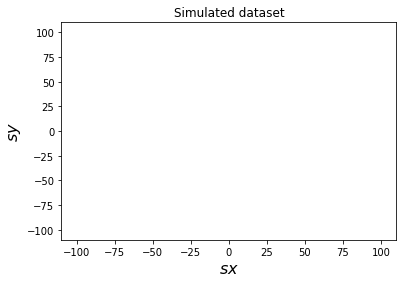

In [42]:
#prepare for plot
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import HTML
history = {"train_loss":[],"test_loss":[]}

ims=[]#animation variable
# sample_s=dist.Normal(dc,dsigma).sample()
# sample_o=dist.Normal(sample_s,dsigma).sample()

grid_inter=20.0

plt.xlim([min_data,max_data])
plt.ylim([min_data,max_data])

plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")

# plt.xticks(np.arange(-2,6,1.0))

100%|██████████| 24/24 [00:00<00:00, 64.90it/s]

Epoch: 1 Train loss: 52329.5234


Test loss: 51748.9492


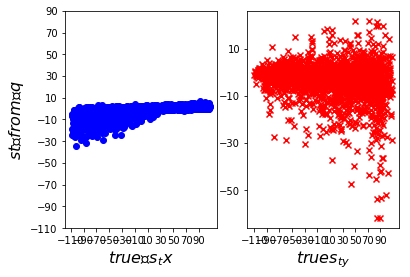

100%|██████████| 24/24 [00:00<00:00, 76.31it/s]

Epoch: 2 Train loss: 51921.4023


Test loss: 51325.9453


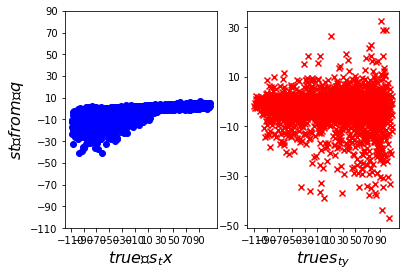

100%|██████████| 24/24 [00:00<00:00, 75.84it/s]

Epoch: 3 Train loss: 51441.3672


Test loss: 50800.1758


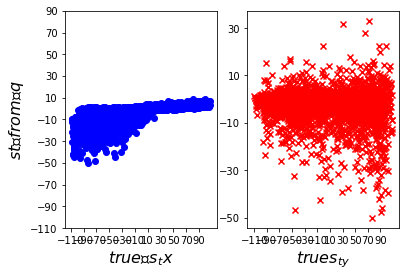

100%|██████████| 24/24 [00:00<00:00, 74.33it/s]

Epoch: 4 Train loss: 50839.8984


Test loss: 50128.1289


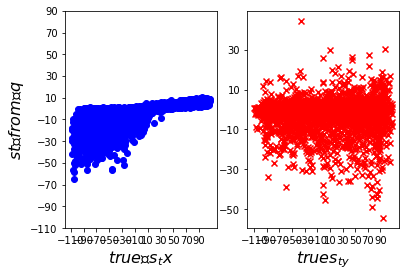

100%|██████████| 24/24 [00:00<00:00, 66.39it/s]

Epoch: 5 Train loss: 50004.0156


Test loss: 49172.9375


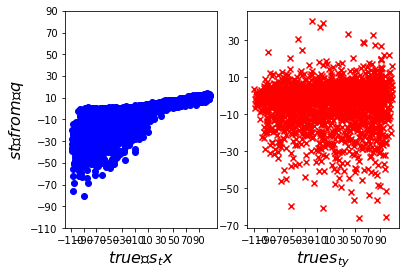

100%|██████████| 24/24 [00:00<00:00, 67.03it/s]

Epoch: 6 Train loss: 48860.2344


Test loss: 47692.8203


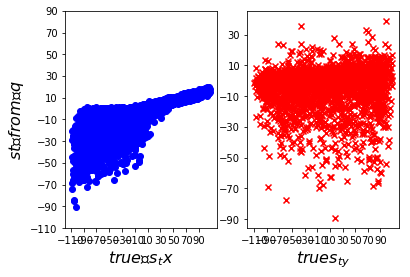

100%|██████████| 24/24 [00:00<00:00, 79.70it/s]

Epoch: 7 Train loss: 46949.0664


Test loss: 45684.1445


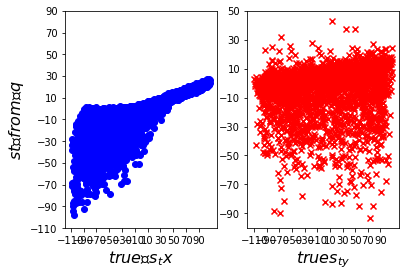

100%|██████████| 24/24 [00:00<00:00, 72.20it/s]

Epoch: 8 Train loss: 44666.3672


Test loss: 42659.7969


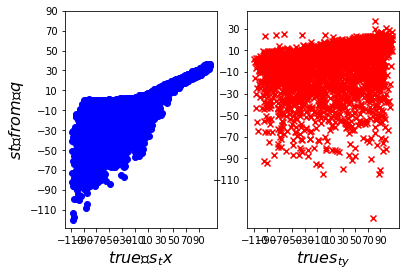

100%|██████████| 24/24 [00:00<00:00, 76.51it/s]

Epoch: 9 Train loss: 41387.1758


Test loss: 39060.4102


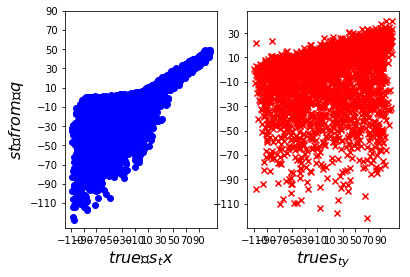

100%|██████████| 24/24 [00:00<00:00, 81.94it/s]

Epoch: 10 Train loss: 38090.6016


Test loss: 35691.2344


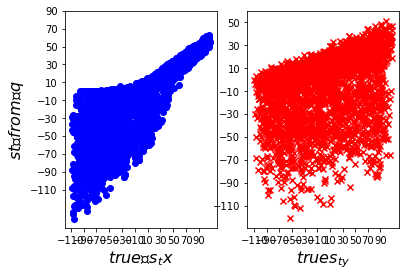

100%|██████████| 24/24 [00:00<00:00, 71.15it/s]

Epoch: 11 Train loss: 35100.3594


Test loss: 32949.9844


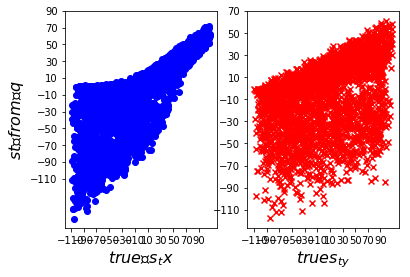

100%|██████████| 24/24 [00:00<00:00, 96.52it/s]

Epoch: 12 Train loss: 32783.1016


Test loss: 30964.4102


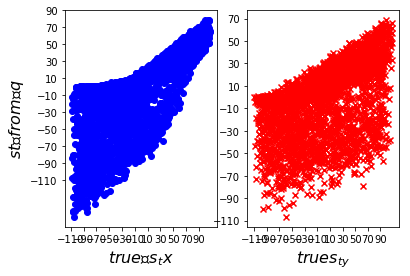

100%|██████████| 24/24 [00:00<00:00, 94.09it/s]

Epoch: 13 Train loss: 31135.5781


Test loss: 29618.0566


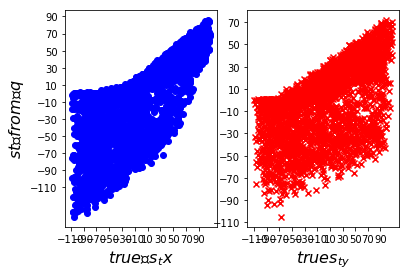

100%|██████████| 24/24 [00:00<00:00, 99.97it/s]

Epoch: 14 Train loss: 29970.5605


Test loss: 28635.4062


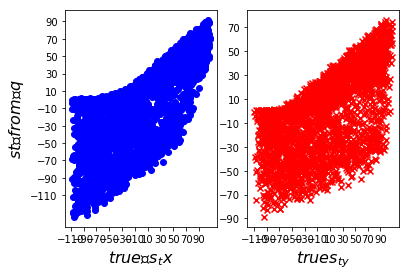

100%|██████████| 24/24 [00:00<00:00, 90.66it/s]

Epoch: 15 Train loss: 29127.6504


Test loss: 27919.5977


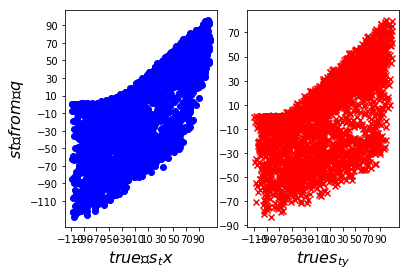

100%|██████████| 24/24 [00:00<00:00, 94.13it/s]

Epoch: 16 Train loss: 28510.3125


Test loss: 27387.4297


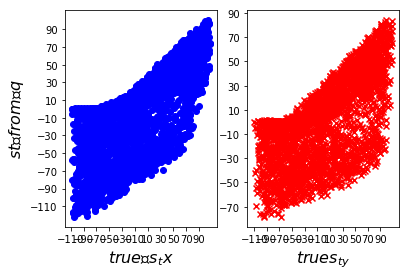

100%|██████████| 24/24 [00:00<00:00, 97.39it/s]

Epoch: 17 Train loss: 28046.0371


Test loss: 26984.6875


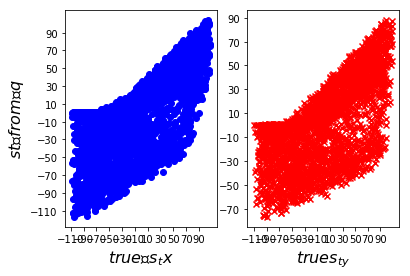

100%|██████████| 24/24 [00:00<00:00, 95.89it/s]

Epoch: 18 Train loss: 27692.1738


Test loss: 26682.0449


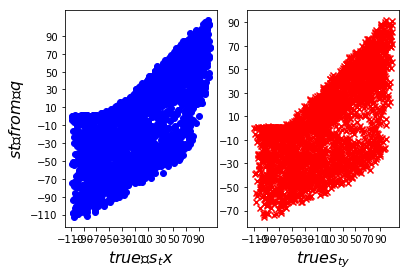

100%|██████████| 24/24 [00:00<00:00, 95.86it/s]

Epoch: 19 Train loss: 27421.5312


Test loss: 26452.8555


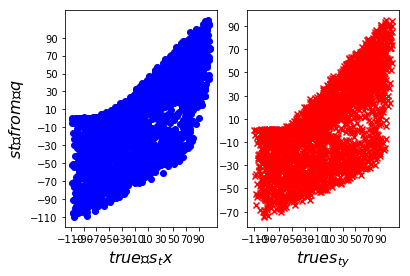

100%|██████████| 24/24 [00:00<00:00, 96.46it/s]

Epoch: 20 Train loss: 27212.2637


Test loss: 26279.3867


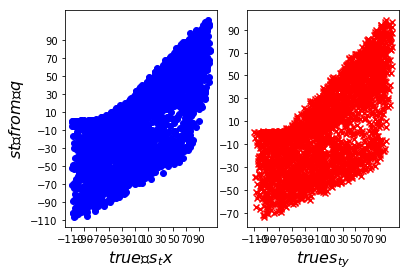

100%|██████████| 24/24 [00:00<00:00, 96.55it/s]

Epoch: 21 Train loss: 27051.1523


Test loss: 26146.2852


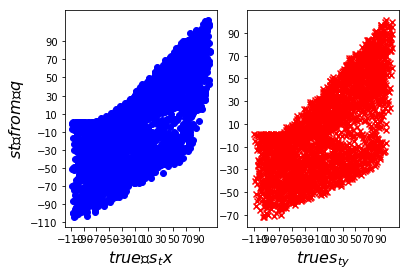

100%|██████████| 24/24 [00:00<00:00, 88.93it/s]

Epoch: 22 Train loss: 26926.5020


Test loss: 26047.2031


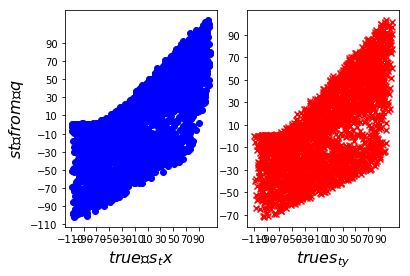

100%|██████████| 24/24 [00:00<00:00, 98.12it/s]

Epoch: 23 Train loss: 26832.1543


Test loss: 25973.0664


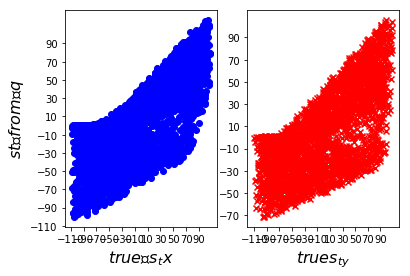

100%|██████████| 24/24 [00:00<00:00, 102.31it/s]

Epoch: 24 Train loss: 26758.5527


Test loss: 25918.9766


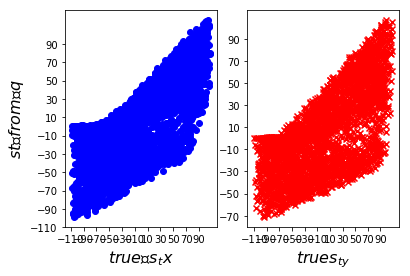

100%|██████████| 24/24 [00:00<00:00, 90.58it/s]

Epoch: 25 Train loss: 26702.2773


Test loss: 25879.1250


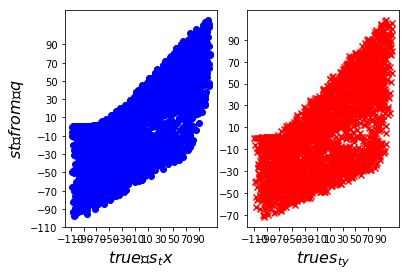

100%|██████████| 24/24 [00:00<00:00, 91.12it/s]

Epoch: 26 Train loss: 26657.9180


Test loss: 25847.8379


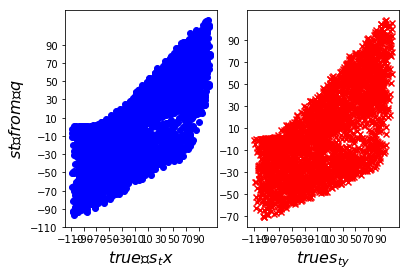

100%|██████████| 24/24 [00:00<00:00, 93.46it/s]

Epoch: 27 Train loss: 26623.8848


Test loss: 25823.9707


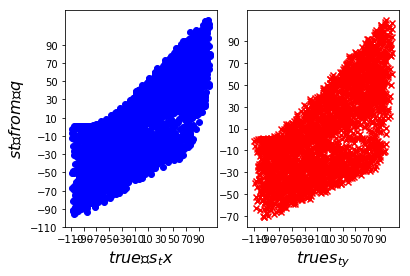

100%|██████████| 24/24 [00:00<00:00, 89.42it/s]

Epoch: 28 Train loss: 26597.8398


Test loss: 25806.0859


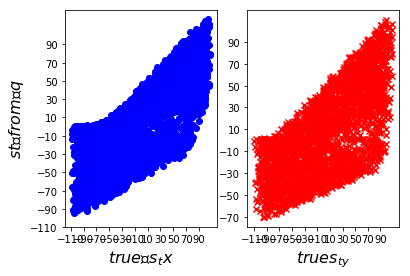

100%|██████████| 24/24 [00:00<00:00, 97.87it/s]

Epoch: 29 Train loss: 26574.6777


Test loss: 25789.8516


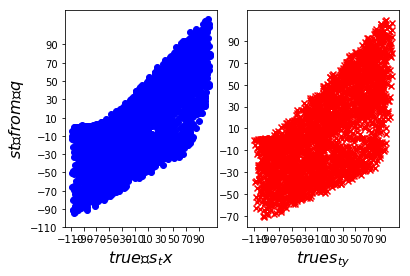

100%|██████████| 24/24 [00:00<00:00, 90.87it/s]

Epoch: 30 Train loss: 26542.2266


Test loss: 25737.6934


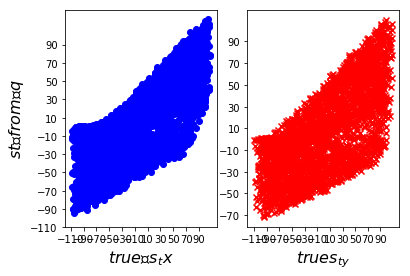

100%|██████████| 24/24 [00:00<00:00, 98.24it/s]

Epoch: 31 Train loss: 26461.4746


Test loss: 25660.0938


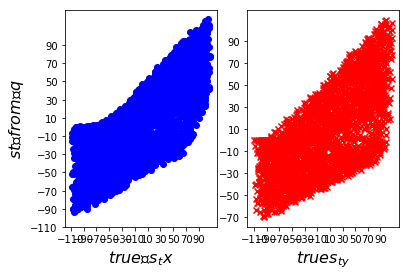

100%|██████████| 24/24 [00:00<00:00, 100.92it/s]

Epoch: 32 Train loss: 26392.6699


Test loss: 25602.0684


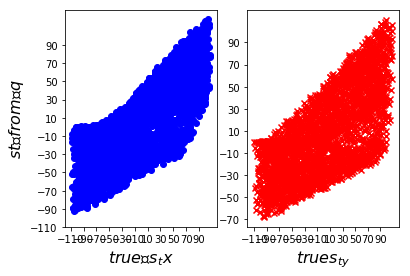

100%|██████████| 24/24 [00:00<00:00, 87.69it/s]

Epoch: 33 Train loss: 26326.2109


Test loss: 25533.2637


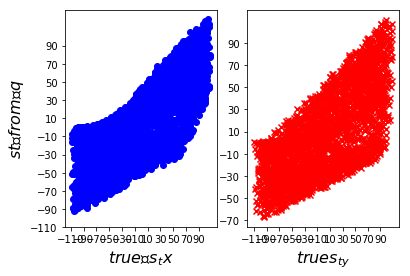

100%|██████████| 24/24 [00:00<00:00, 100.23it/s]

Epoch: 34 Train loss: 26244.2285


Test loss: 25444.4609


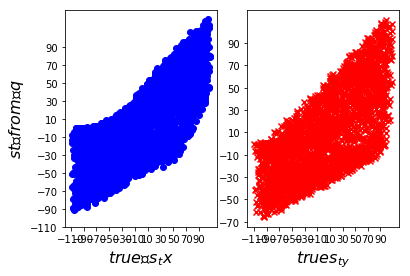

100%|██████████| 24/24 [00:00<00:00, 86.47it/s]

Epoch: 35 Train loss: 26142.2285


Test loss: 25329.3125


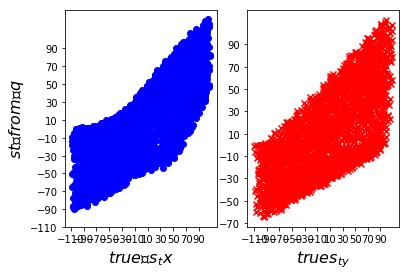

100%|██████████| 24/24 [00:00<00:00, 98.27it/s]

Epoch: 36 Train loss: 26013.7871


Test loss: 25183.8418


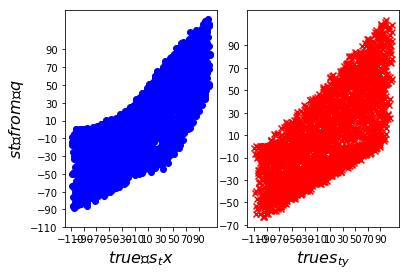

100%|██████████| 24/24 [00:00<00:00, 102.07it/s]

Epoch: 37 Train loss: 25851.3066


Test loss: 25005.7871


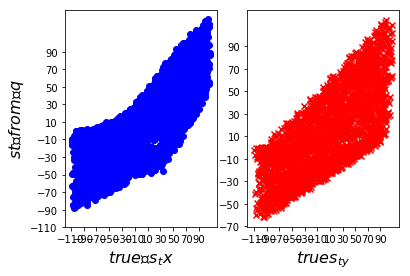

100%|██████████| 24/24 [00:00<00:00, 102.44it/s]

Epoch: 38 Train loss: 25655.9219


Test loss: 24795.6504


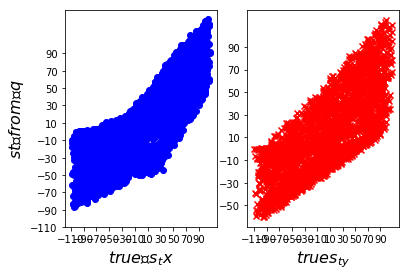

100%|██████████| 24/24 [00:00<00:00, 98.75it/s]

Epoch: 39 Train loss: 25436.6348


Test loss: 24553.7715


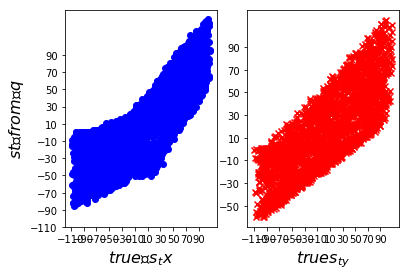

100%|██████████| 24/24 [00:00<00:00, 87.60it/s]

Epoch: 40 Train loss: 25190.7598


Test loss: 24293.5176


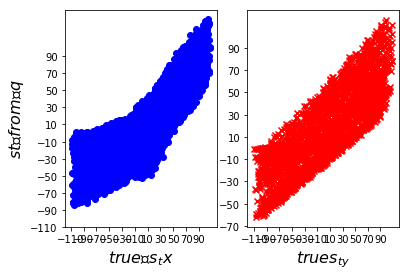

100%|██████████| 24/24 [00:00<00:00, 79.31it/s]

Epoch: 41 Train loss: 24935.0078


Test loss: 24030.5332


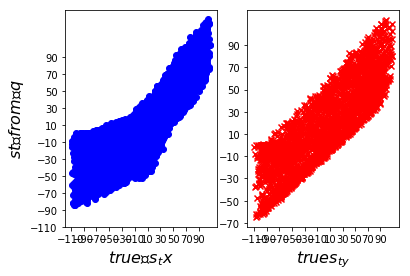

100%|██████████| 24/24 [00:00<00:00, 89.25it/s]

Epoch: 42 Train loss: 24682.9121


Test loss: 23779.5742


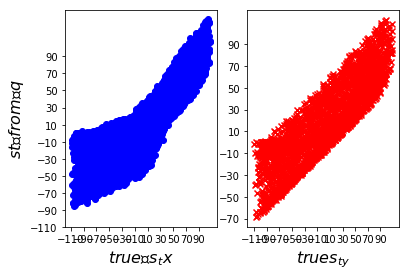

100%|██████████| 24/24 [00:00<00:00, 97.28it/s]

Epoch: 43 Train loss: 24444.5547


Test loss: 23546.2266


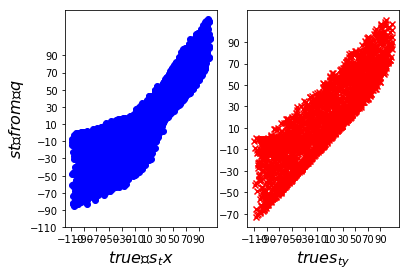

100%|██████████| 24/24 [00:00<00:00, 94.51it/s]

Epoch: 44 Train loss: 24221.2168


Test loss: 23331.3711


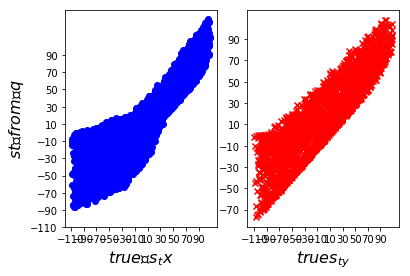

100%|██████████| 24/24 [00:00<00:00, 87.87it/s]

Epoch: 45 Train loss: 24014.6836


Test loss: 23133.5469


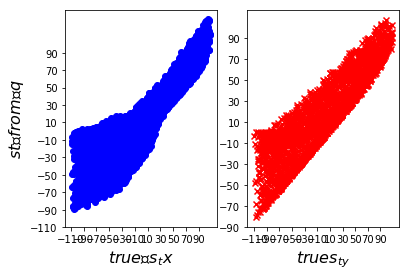

100%|██████████| 24/24 [00:00<00:00, 98.29it/s]

Epoch: 46 Train loss: 23826.1543


Test loss: 22955.5684


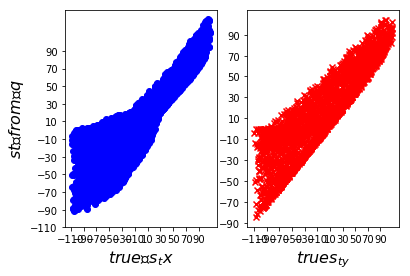

100%|██████████| 24/24 [00:00<00:00, 82.78it/s]

Epoch: 47 Train loss: 23652.1172


Test loss: 22791.8164


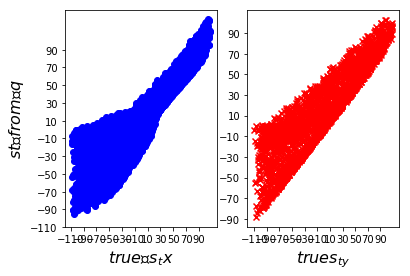

100%|██████████| 24/24 [00:00<00:00, 94.67it/s]

Epoch: 48 Train loss: 23492.1328


Test loss: 22644.1328


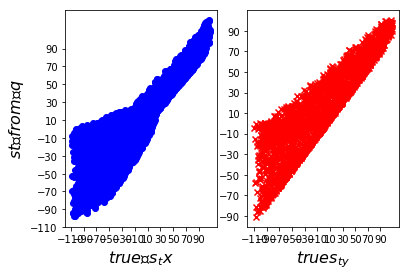

100%|██████████| 24/24 [00:00<00:00, 75.36it/s]

Epoch: 49 Train loss: 23342.7578


Test loss: 22506.0586


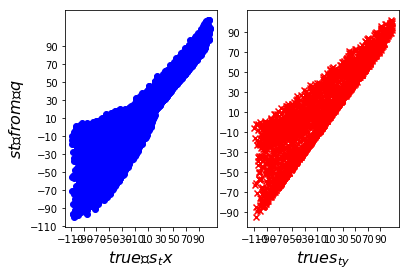

100%|██████████| 24/24 [00:00<00:00, 46.37it/s]

Epoch: 50 Train loss: 23204.3281


Test loss: 22382.6191


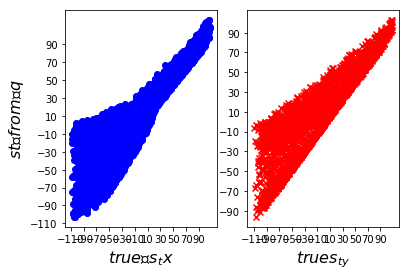

100%|██████████| 24/24 [00:00<00:00, 82.25it/s]

Epoch: 51 Train loss: 23079.1172


Test loss: 22269.8594


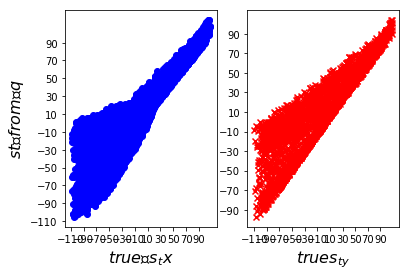

100%|██████████| 24/24 [00:00<00:00, 93.58it/s]

Epoch: 52 Train loss: 22963.4023


Test loss: 22169.5547


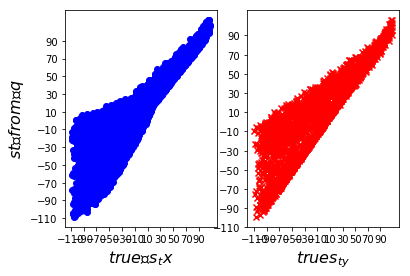

100%|██████████| 24/24 [00:00<00:00, 95.23it/s]

Epoch: 53 Train loss: 22857.3145


Test loss: 22077.3711


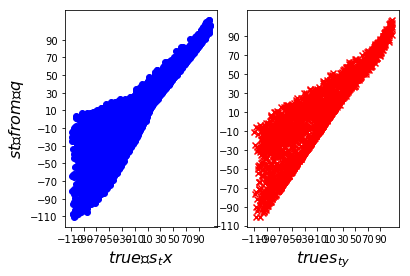

100%|██████████| 24/24 [00:00<00:00, 96.45it/s]

Epoch: 54 Train loss: 22759.4648


Test loss: 21992.5312


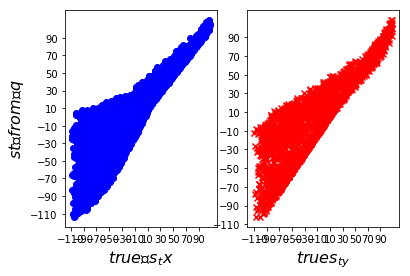

100%|██████████| 24/24 [00:00<00:00, 84.29it/s]

Epoch: 55 Train loss: 22666.7070


Test loss: 21913.3633


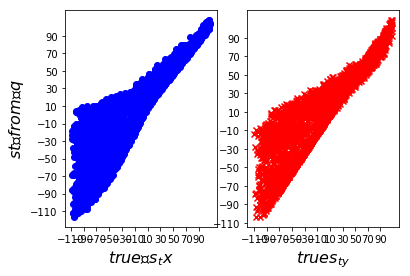

100%|██████████| 24/24 [00:00<00:00, 90.64it/s]

Epoch: 56 Train loss: 22577.6074


Test loss: 21815.5586


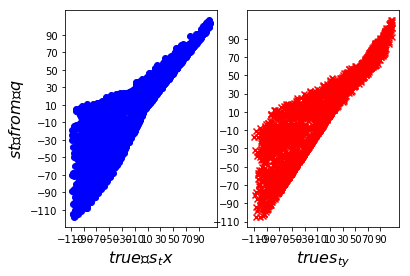

100%|██████████| 24/24 [00:00<00:00, 93.89it/s]

Epoch: 57 Train loss: 22339.3516


Test loss: 21528.5527


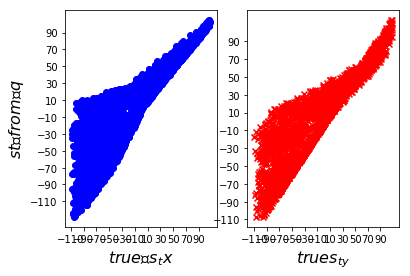

100%|██████████| 24/24 [00:00<00:00, 85.30it/s]

Epoch: 58 Train loss: 22024.0566


Test loss: 21238.5898


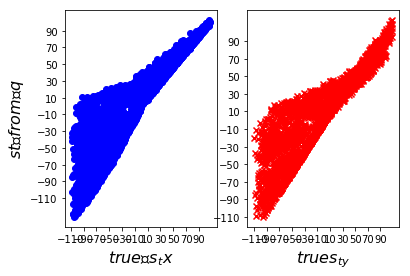

100%|██████████| 24/24 [00:00<00:00, 72.65it/s]

Epoch: 59 Train loss: 21613.8574


Test loss: 20738.3359


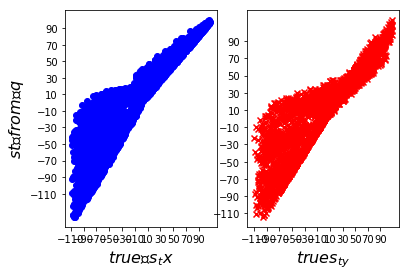

100%|██████████| 24/24 [00:00<00:00, 92.70it/s]

Epoch: 60 Train loss: 20743.7031


Test loss: 19542.6465


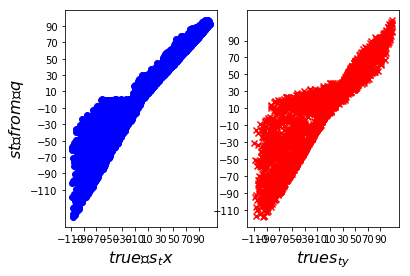

100%|██████████| 24/24 [00:00<00:00, 90.83it/s]

Epoch: 61 Train loss: 18706.8027


Test loss: 16869.7520


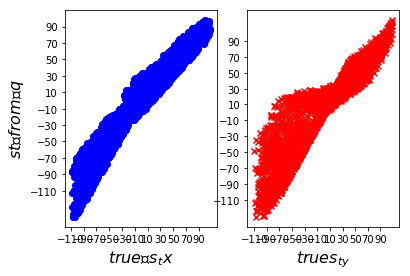

100%|██████████| 24/24 [00:00<00:00, 92.48it/s]

Epoch: 62 Train loss: 15304.3760


Test loss: 13328.6084


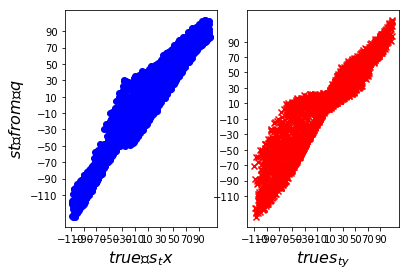

100%|██████████| 24/24 [00:00<00:00, 93.83it/s]

Epoch: 63 Train loss: 12290.6055


Test loss: 11229.1973


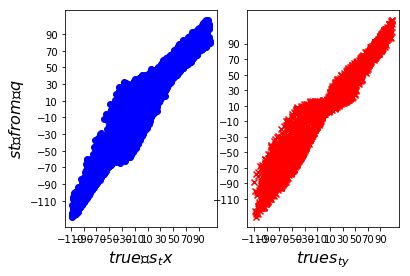

100%|██████████| 24/24 [00:00<00:00, 85.31it/s]

Epoch: 64 Train loss: 10765.9453


Test loss: 10170.8760


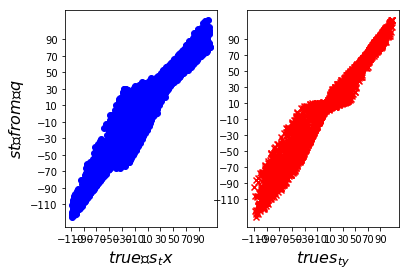

100%|██████████| 24/24 [00:00<00:00, 95.53it/s]

Epoch: 65 Train loss: 9826.1377


Test loss: 9389.5098


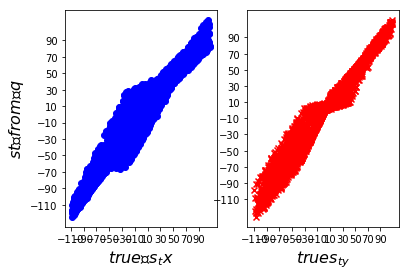

100%|██████████| 24/24 [00:00<00:00, 82.70it/s]

Epoch: 66 Train loss: 8954.6885


Test loss: 8447.2598


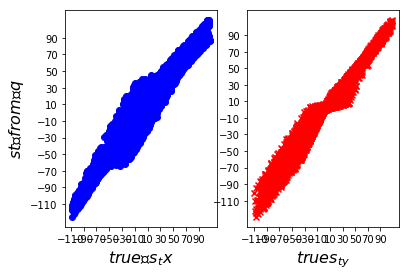

100%|██████████| 24/24 [00:00<00:00, 75.78it/s]

Epoch: 67 Train loss: 7710.3672


Test loss: 6791.4751


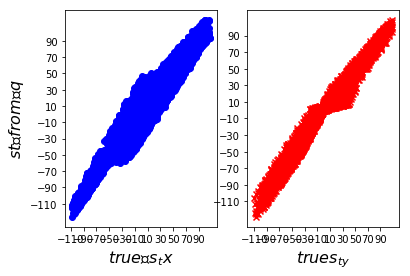

100%|██████████| 24/24 [00:00<00:00, 74.22it/s]

Epoch: 68 Train loss: 5580.9146


Test loss: 4268.1724


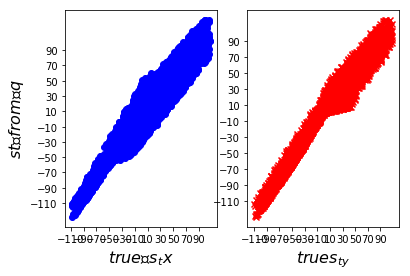

100%|██████████| 24/24 [00:00<00:00, 84.68it/s]

Epoch: 69 Train loss: 3206.6716


Test loss: 2477.2629


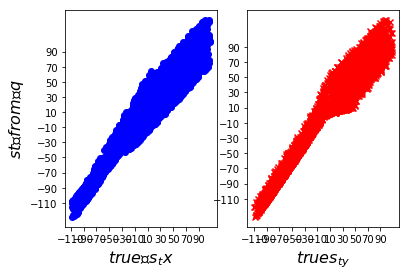

100%|██████████| 24/24 [00:00<00:00, 90.63it/s]

Epoch: 70 Train loss: 2048.4570


Test loss: 1752.0713


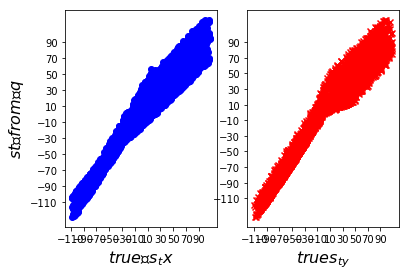

100%|██████████| 24/24 [00:00<00:00, 90.46it/s]

Epoch: 71 Train loss: 1557.6359


Test loss: 1414.0920


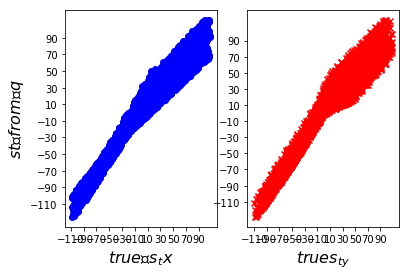

100%|██████████| 24/24 [00:00<00:00, 91.60it/s]

Epoch: 72 Train loss: 1305.9691


Test loss: 1218.1669


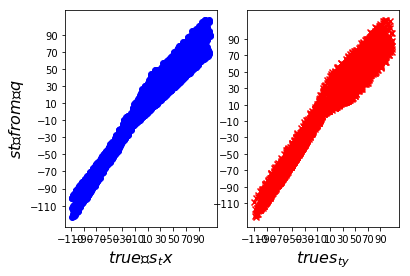

100%|██████████| 24/24 [00:00<00:00, 79.03it/s]


Epoch: 73 Train loss: 1143.9087
Test loss: 1077.2329


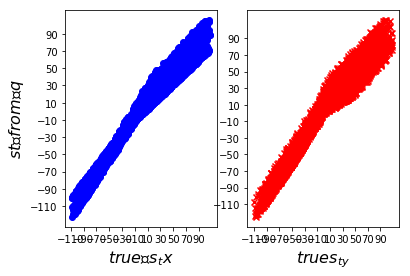

100%|██████████| 24/24 [00:00<00:00, 72.75it/s]

Epoch: 74 Train loss: 1017.2469


Test loss: 963.0652


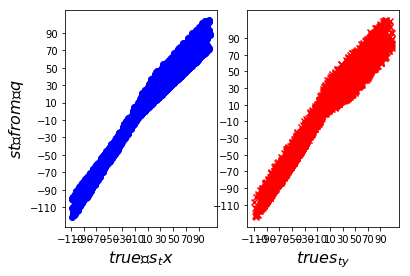

100%|██████████| 24/24 [00:00<00:00, 75.53it/s]

Epoch: 75 Train loss: 912.0379


Test loss: 864.1286


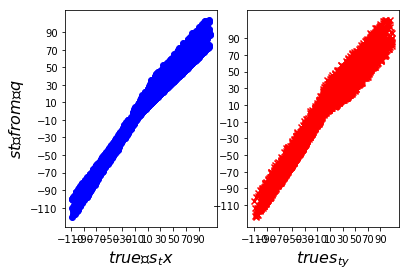

100%|██████████| 24/24 [00:00<00:00, 72.87it/s]

Epoch: 76 Train loss: 822.7573


Test loss: 779.5967


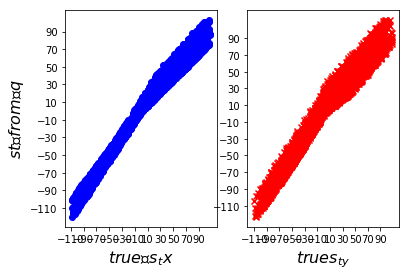

100%|██████████| 24/24 [00:00<00:00, 90.39it/s]

Epoch: 77 Train loss: 745.7449


Test loss: 707.4621


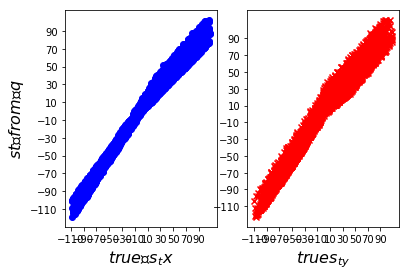

100%|██████████| 24/24 [00:00<00:00, 91.30it/s]

Epoch: 78 Train loss: 677.4283


Test loss: 640.5539


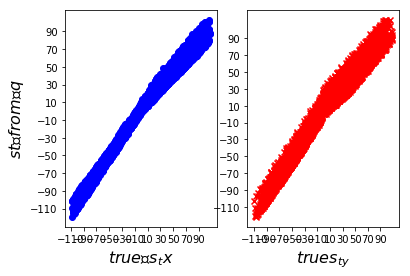

100%|██████████| 24/24 [00:00<00:00, 76.88it/s]

Epoch: 79 Train loss: 614.9155


Test loss: 578.2025


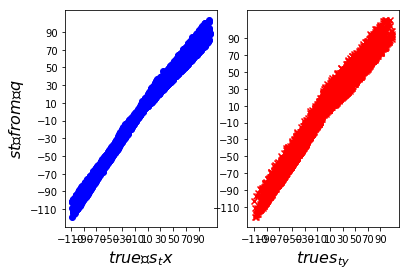

100%|██████████| 24/24 [00:00<00:00, 79.65it/s]

Epoch: 80 Train loss: 560.8056


Test loss: 527.3560


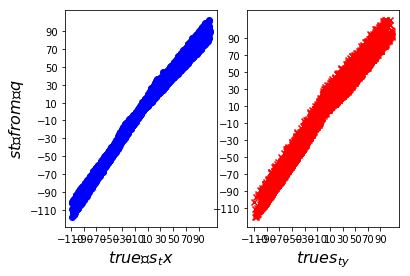

100%|██████████| 24/24 [00:00<00:00, 75.35it/s]

Epoch: 81 Train loss: 514.9508


Test loss: 485.6010


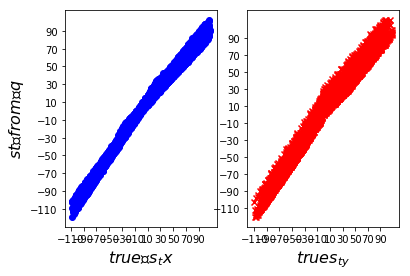

100%|██████████| 24/24 [00:00<00:00, 83.49it/s]

Epoch: 82 Train loss: 474.8815


Test loss: 448.5247


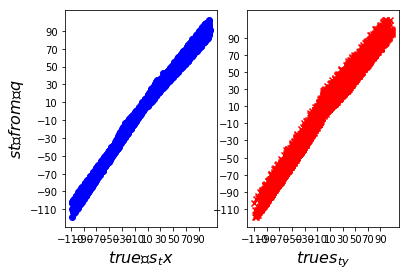

100%|██████████| 24/24 [00:00<00:00, 76.34it/s]

Epoch: 83 Train loss: 439.0771


Test loss: 415.8471


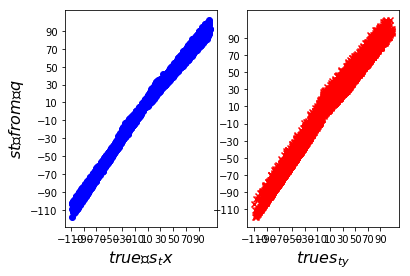

100%|██████████| 24/24 [00:00<00:00, 86.69it/s]

Epoch: 84 Train loss: 405.9802


Test loss: 385.3672


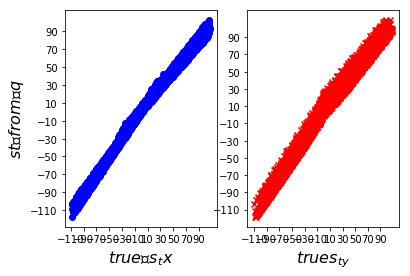

100%|██████████| 24/24 [00:00<00:00, 87.10it/s]

Epoch: 85 Train loss: 377.9196


Test loss: 359.1948


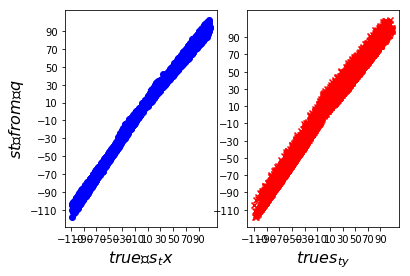

100%|██████████| 24/24 [00:00<00:00, 76.96it/s]

Epoch: 86 Train loss: 353.0798


Test loss: 336.6504


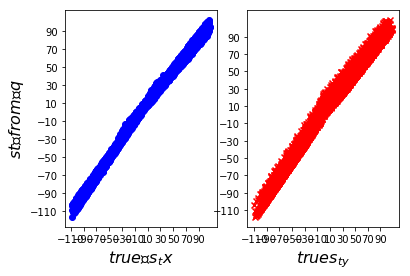

100%|██████████| 24/24 [00:00<00:00, 86.65it/s]

Epoch: 87 Train loss: 330.1850


Test loss: 315.7105


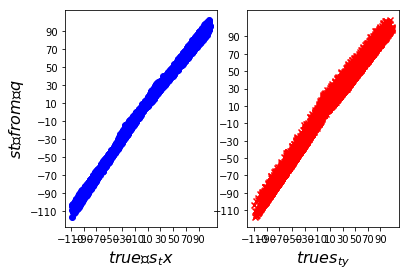

100%|██████████| 24/24 [00:00<00:00, 75.92it/s]

Epoch: 88 Train loss: 309.7543


Test loss: 296.8616


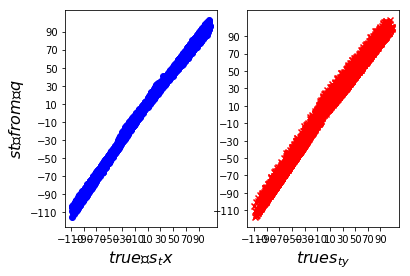

100%|██████████| 24/24 [00:00<00:00, 82.86it/s]

Epoch: 89 Train loss: 293.3389


Test loss: 280.9422


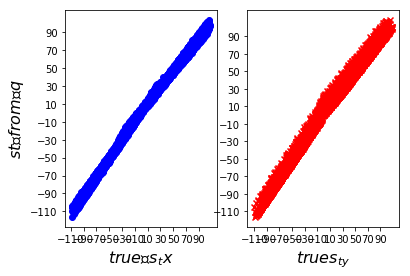

100%|██████████| 24/24 [00:00<00:00, 83.58it/s]

Epoch: 90 Train loss: 275.8517


Test loss: 265.8402


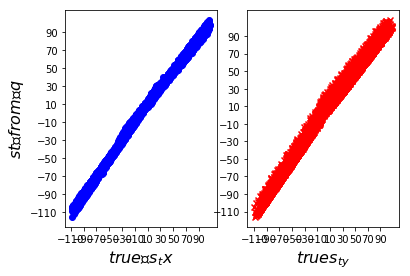

100%|██████████| 24/24 [00:00<00:00, 78.28it/s]

Epoch: 91 Train loss: 260.1840


Test loss: 250.7301


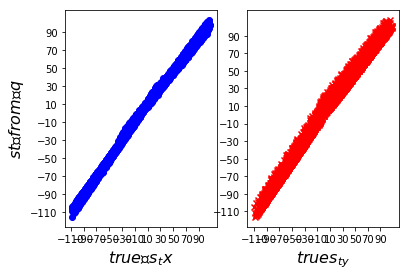

100%|██████████| 24/24 [00:00<00:00, 74.67it/s]

Epoch: 92 Train loss: 246.0103


Test loss: 237.5211


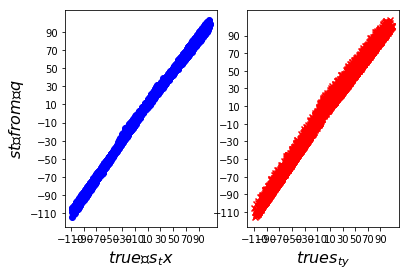

100%|██████████| 24/24 [00:00<00:00, 74.87it/s]

Epoch: 93 Train loss: 233.1594


Test loss: 225.0184


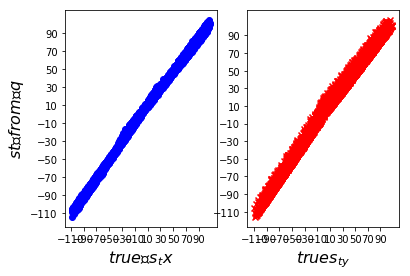

100%|██████████| 24/24 [00:00<00:00, 87.28it/s]

Epoch: 94 Train loss: 220.3820


Test loss: 213.0822


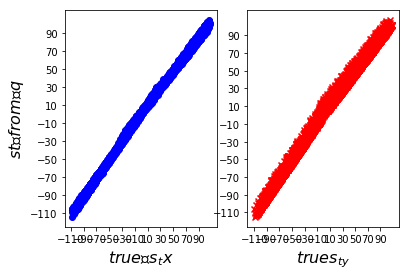

100%|██████████| 24/24 [00:00<00:00, 73.50it/s]

Epoch: 95 Train loss: 208.8668


Test loss: 201.8622


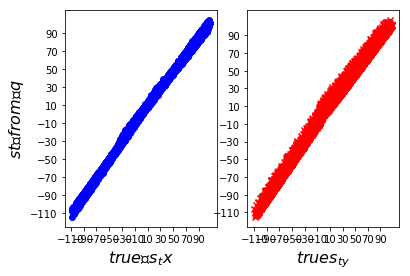

100%|██████████| 24/24 [00:00<00:00, 73.25it/s]

Epoch: 96 Train loss: 197.4670


Test loss: 191.4636


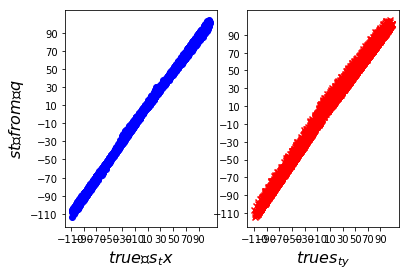

100%|██████████| 24/24 [00:00<00:00, 83.24it/s]

Epoch: 97 Train loss: 187.0886


Test loss: 181.8809


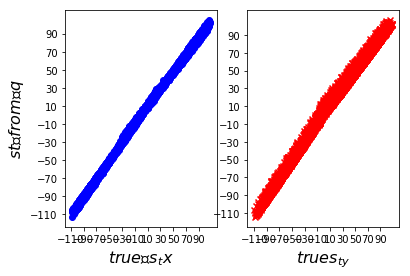

100%|██████████| 24/24 [00:00<00:00, 83.52it/s]

Epoch: 98 Train loss: 178.7499


Test loss: 171.9495


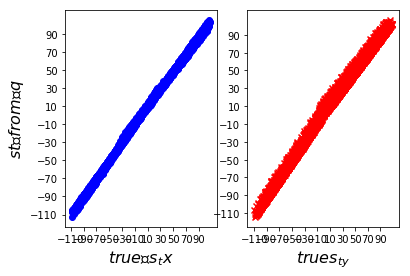

100%|██████████| 24/24 [00:00<00:00, 85.24it/s]

Epoch: 99 Train loss: 169.2606


Test loss: 163.0265


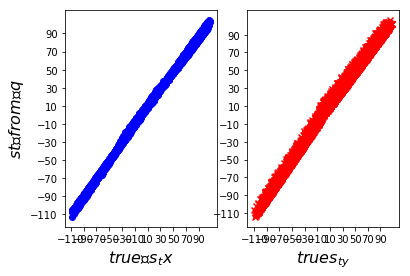

100%|██████████| 24/24 [00:00<00:00, 84.60it/s]

Epoch: 100 Train loss: 160.5041


Test loss: 154.2287


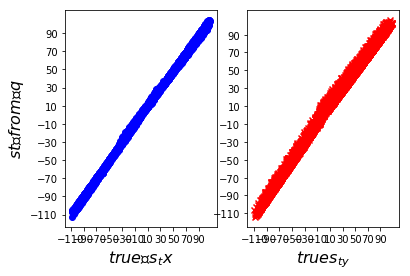

100%|██████████| 24/24 [00:00<00:00, 83.88it/s]

Epoch: 101 Train loss: 152.5316


Test loss: 145.9970


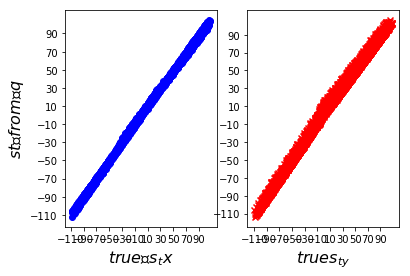

100%|██████████| 24/24 [00:00<00:00, 84.01it/s]

Epoch: 102 Train loss: 144.6410


Test loss: 137.9920


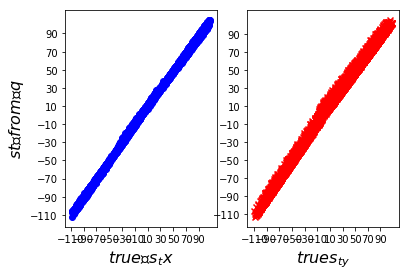

100%|██████████| 24/24 [00:00<00:00, 65.78it/s]

Epoch: 103 Train loss: 136.9850


Test loss: 130.6174


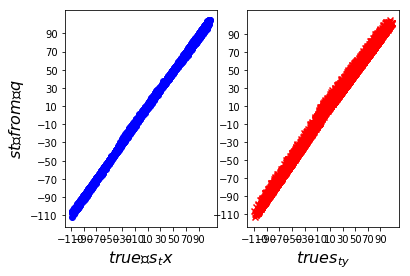

100%|██████████| 24/24 [00:00<00:00, 70.72it/s]

Epoch: 104 Train loss: 129.5118


Test loss: 123.8973


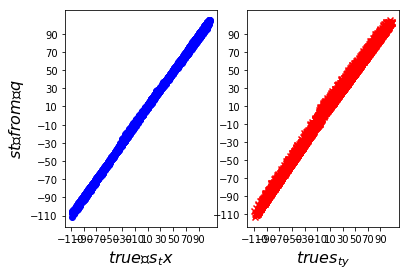

100%|██████████| 24/24 [00:00<00:00, 82.57it/s]

Epoch: 105 Train loss: 122.6513


Test loss: 116.8745


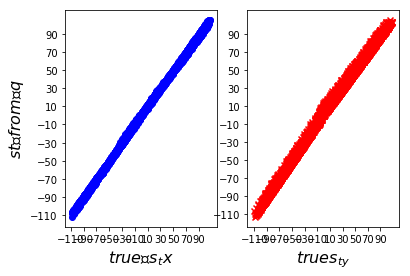

100%|██████████| 24/24 [00:00<00:00, 69.09it/s]

Epoch: 106 Train loss: 116.0878


Test loss: 111.1191


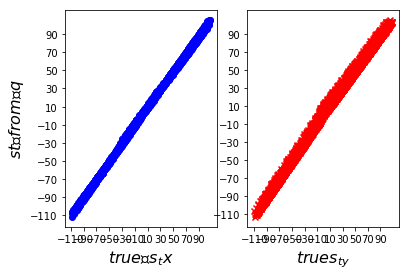

100%|██████████| 24/24 [00:00<00:00, 76.02it/s]

Epoch: 107 Train loss: 109.9309


Test loss: 105.4145


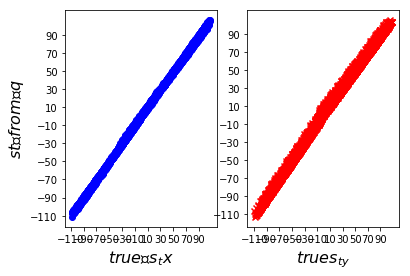

100%|██████████| 24/24 [00:00<00:00, 82.64it/s]

Epoch: 108 Train loss: 104.2458


Test loss: 99.9418


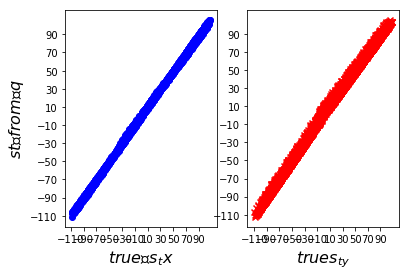

100%|██████████| 24/24 [00:00<00:00, 66.94it/s]

Epoch: 109 Train loss: 98.4917


Test loss: 94.3782


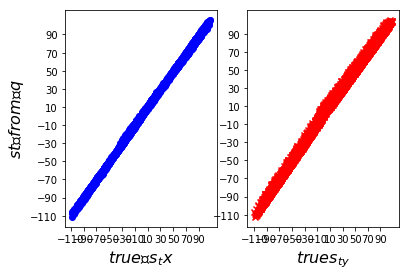

100%|██████████| 24/24 [00:00<00:00, 66.61it/s]

Epoch: 110 Train loss: 93.9495


Test loss: 89.5659


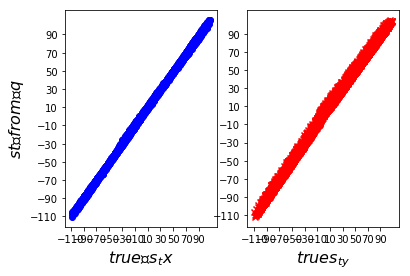

100%|██████████| 24/24 [00:00<00:00, 79.10it/s]


Epoch: 111 Train loss: 88.9696
Test loss: 84.8330


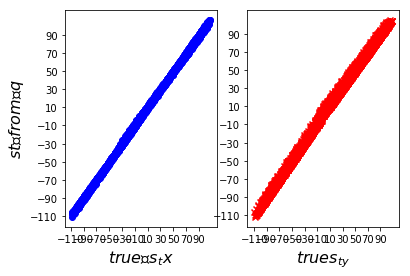

100%|██████████| 24/24 [00:00<00:00, 81.13it/s]

Epoch: 112 Train loss: 85.0717


Test loss: 80.6408


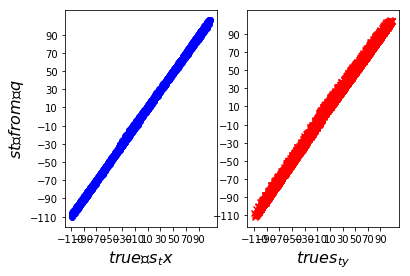

100%|██████████| 24/24 [00:00<00:00, 85.98it/s]

Epoch: 113 Train loss: 80.5566


Test loss: 77.0997


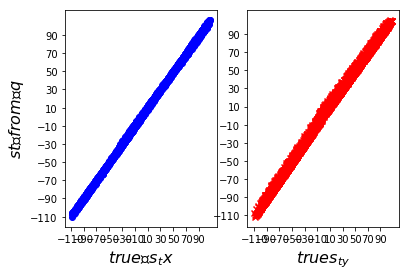

100%|██████████| 24/24 [00:00<00:00, 81.79it/s]

Epoch: 114 Train loss: 76.5253


Test loss: 73.4884


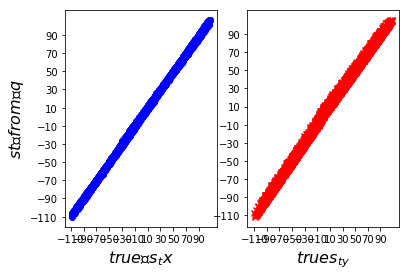

100%|██████████| 24/24 [00:00<00:00, 73.50it/s]

Epoch: 115 Train loss: 72.6090


Test loss: 69.5933


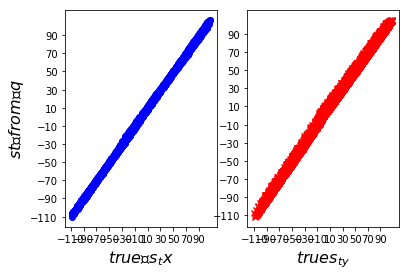

100%|██████████| 24/24 [00:00<00:00, 79.86it/s]


Epoch: 116 Train loss: 69.4821
Test loss: 66.2915


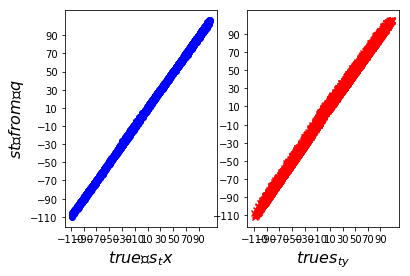

100%|██████████| 24/24 [00:00<00:00, 62.04it/s]

Epoch: 117 Train loss: 66.4636


Test loss: 63.5390


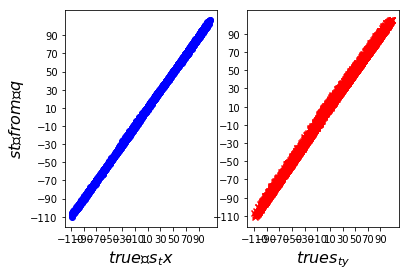

100%|██████████| 24/24 [00:00<00:00, 84.46it/s]

Epoch: 118 Train loss: 62.8880


Test loss: 60.4531


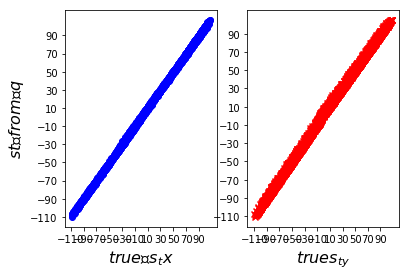

100%|██████████| 24/24 [00:00<00:00, 73.87it/s]

Epoch: 119 Train loss: 59.9377


Test loss: 57.9251


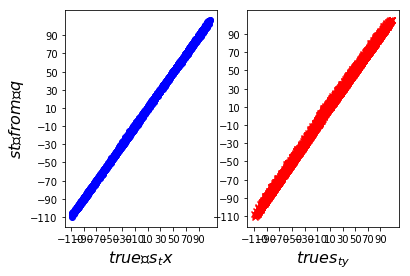

100%|██████████| 24/24 [00:00<00:00, 84.19it/s]

Epoch: 120 Train loss: 57.3563


Test loss: 54.9184


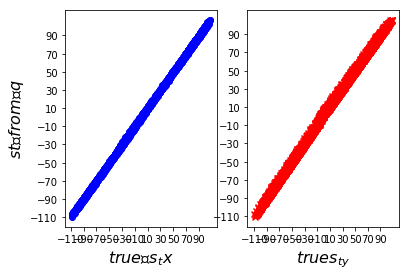

100%|██████████| 24/24 [00:00<00:00, 63.49it/s]

Epoch: 121 Train loss: 54.8727


Test loss: 52.7059


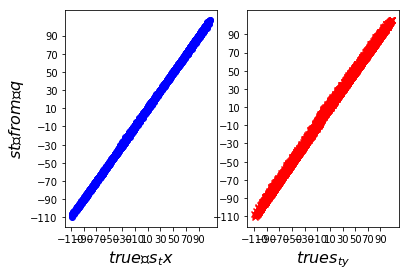

100%|██████████| 24/24 [00:00<00:00, 63.72it/s]

Epoch: 122 Train loss: 51.9542


Test loss: 50.0362


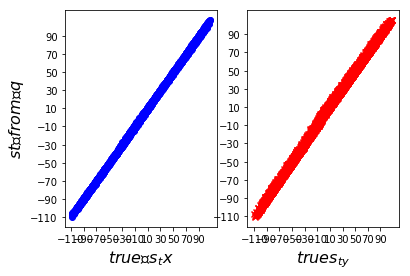

100%|██████████| 24/24 [00:00<00:00, 78.78it/s]


Epoch: 123 Train loss: 49.8129
Test loss: 47.7971


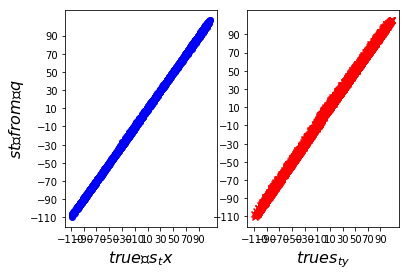

100%|██████████| 24/24 [00:00<00:00, 78.05it/s]

Epoch: 124 Train loss: 47.5782


Test loss: 45.7702


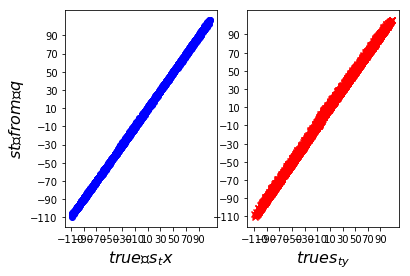

100%|██████████| 24/24 [00:00<00:00, 82.98it/s]

Epoch: 125 Train loss: 45.4208


Test loss: 43.9296


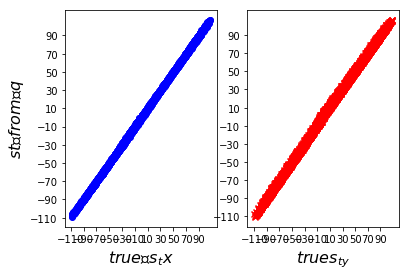

100%|██████████| 24/24 [00:00<00:00, 83.87it/s]

Epoch: 126 Train loss: 43.3287


Test loss: 41.9561


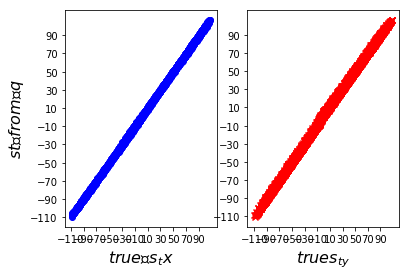

100%|██████████| 24/24 [00:00<00:00, 64.95it/s]

Epoch: 127 Train loss: 41.6134


Test loss: 40.2816


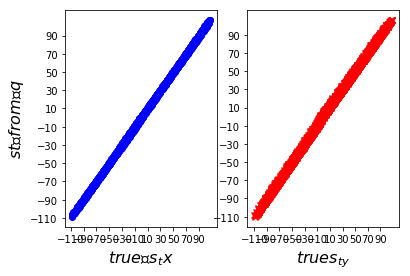

100%|██████████| 24/24 [00:00<00:00, 82.74it/s]

Epoch: 128 Train loss: 39.5661


Test loss: 38.4500


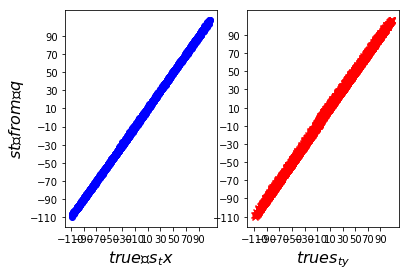

100%|██████████| 24/24 [00:00<00:00, 76.48it/s]

Epoch: 129 Train loss: 37.9238


Test loss: 36.9321


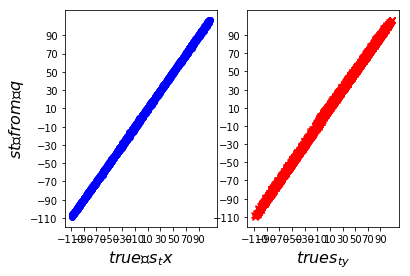

100%|██████████| 24/24 [00:00<00:00, 79.75it/s]


Epoch: 130 Train loss: 36.4346
Test loss: 35.2749


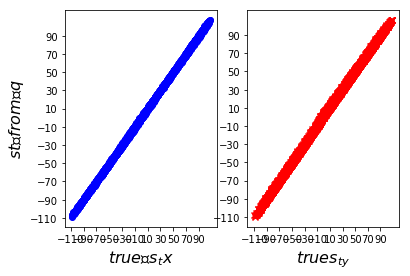

100%|██████████| 24/24 [00:00<00:00, 78.47it/s]

Epoch: 131 Train loss: 35.0296


Test loss: 33.6866


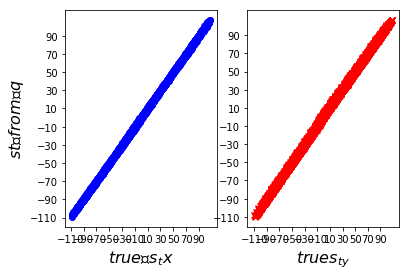

100%|██████████| 24/24 [00:00<00:00, 63.16it/s]

Epoch: 132 Train loss: 33.3939


Test loss: 32.6226


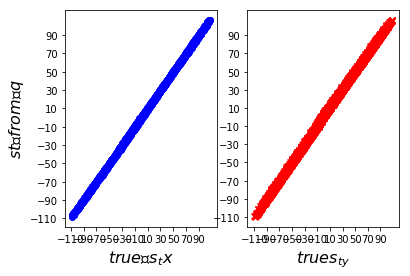

100%|██████████| 24/24 [00:00<00:00, 77.99it/s]

Epoch: 133 Train loss: 32.2515


Test loss: 31.4085


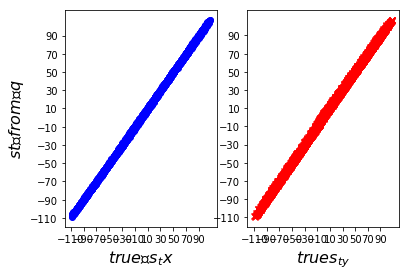

100%|██████████| 24/24 [00:00<00:00, 66.44it/s]

Epoch: 134 Train loss: 31.1174


Test loss: 29.8852


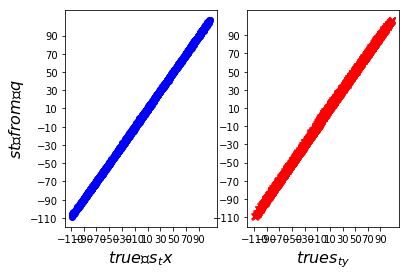

100%|██████████| 24/24 [00:00<00:00, 82.72it/s]

Epoch: 135 Train loss: 29.8757


Test loss: 28.7920


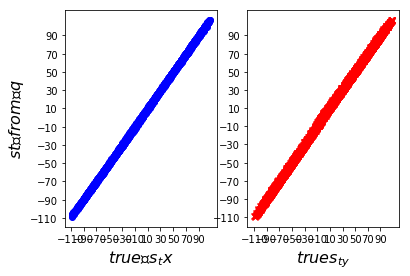

100%|██████████| 24/24 [00:00<00:00, 82.47it/s]

Epoch: 136 Train loss: 28.5303


Test loss: 27.2997


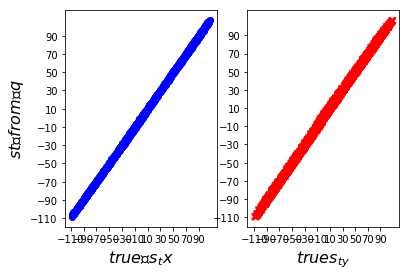

100%|██████████| 24/24 [00:00<00:00, 78.71it/s]


Epoch: 137 Train loss: 27.3875
Test loss: 26.4885


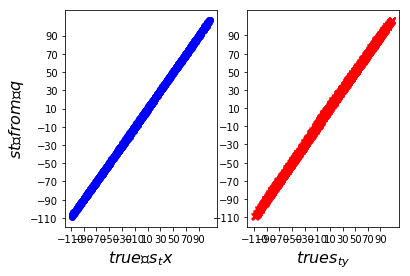

100%|██████████| 24/24 [00:00<00:00, 81.16it/s]

Epoch: 138 Train loss: 26.3222


Test loss: 25.1041


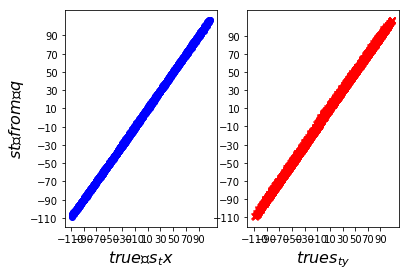

100%|██████████| 24/24 [00:00<00:00, 78.55it/s]

Epoch: 139 Train loss: 25.2090


Test loss: 24.5570


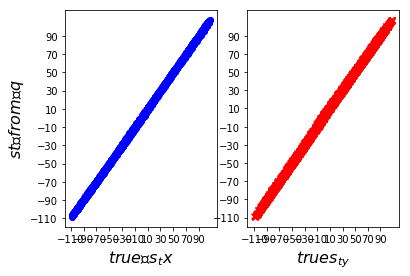

100%|██████████| 24/24 [00:00<00:00, 62.93it/s]

Epoch: 140 Train loss: 24.1297


Test loss: 23.3335


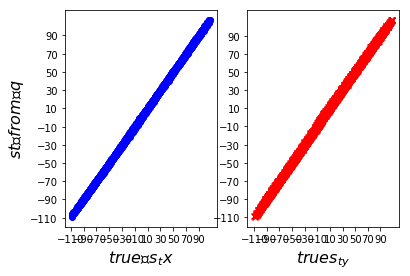

100%|██████████| 24/24 [00:00<00:00, 78.87it/s]

Epoch: 141 Train loss: 23.1718


Test loss: 22.4728


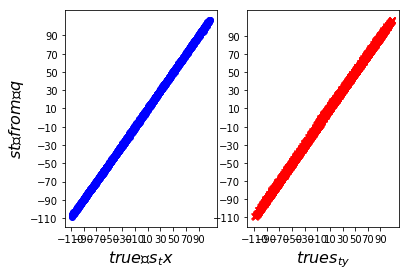

100%|██████████| 24/24 [00:00<00:00, 69.45it/s]

Epoch: 142 Train loss: 22.3552


Test loss: 21.5913


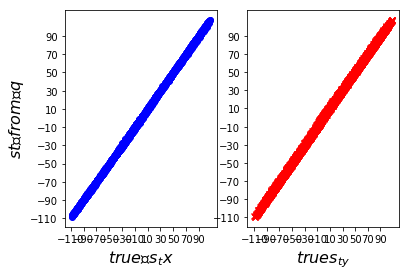

100%|██████████| 24/24 [00:00<00:00, 81.13it/s]

Epoch: 143 Train loss: 21.3039


Test loss: 20.6679


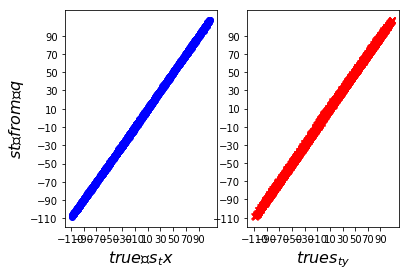

100%|██████████| 24/24 [00:00<00:00, 81.28it/s]

Epoch: 144 Train loss: 20.3270


Test loss: 19.8474


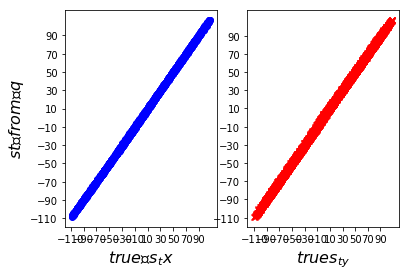

100%|██████████| 24/24 [00:00<00:00, 81.18it/s]

Epoch: 145 Train loss: 19.4129


Test loss: 18.9595


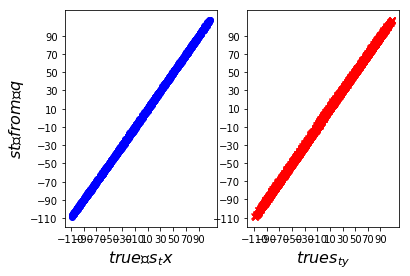

100%|██████████| 24/24 [00:00<00:00, 81.57it/s]

Epoch: 146 Train loss: 18.9472


Test loss: 17.9211


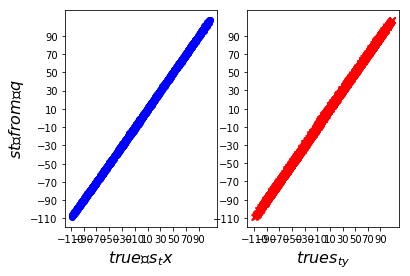

100%|██████████| 24/24 [00:00<00:00, 62.61it/s]

Epoch: 147 Train loss: 18.0464


Test loss: 17.3064


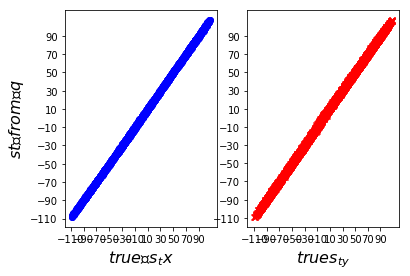

100%|██████████| 24/24 [00:00<00:00, 80.55it/s]

Epoch: 148 Train loss: 17.1980


Test loss: 16.8434


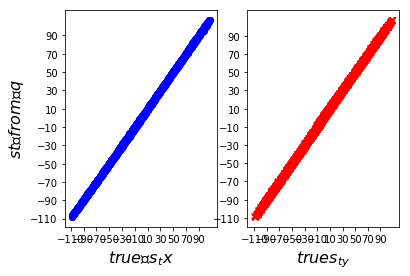

100%|██████████| 24/24 [00:00<00:00, 77.65it/s]

Epoch: 149 Train loss: 16.5548


Test loss: 15.8556


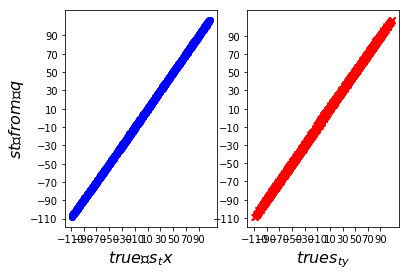

100%|██████████| 24/24 [00:00<00:00, 80.57it/s]

Epoch: 150 Train loss: 15.9233


Test loss: 15.2771


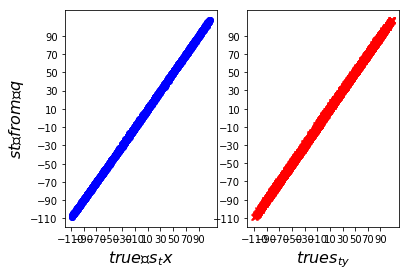

100%|██████████| 24/24 [00:00<00:00, 61.41it/s]

Epoch: 151 Train loss: 15.4117


Test loss: 14.7539


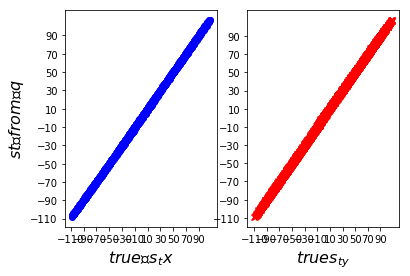

100%|██████████| 24/24 [00:00<00:00, 73.12it/s]

Epoch: 152 Train loss: 14.8489


Test loss: 14.0547


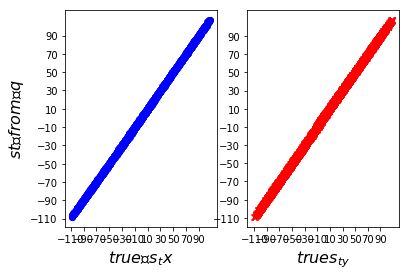

100%|██████████| 24/24 [00:00<00:00, 76.56it/s]

Epoch: 153 Train loss: 14.3276


Test loss: 13.8350


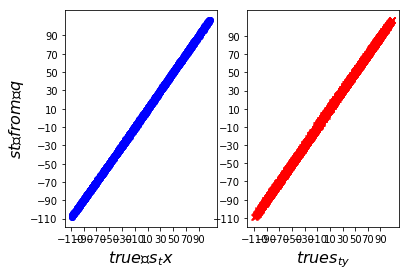

100%|██████████| 24/24 [00:00<00:00, 68.68it/s]

Epoch: 154 Train loss: 13.8091


Test loss: 13.2569


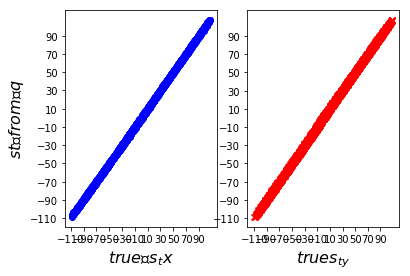

100%|██████████| 24/24 [00:00<00:00, 73.94it/s]

Epoch: 155 Train loss: 13.2110


Test loss: 12.8714


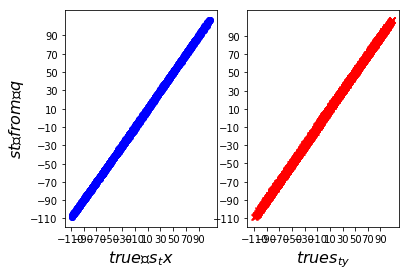

100%|██████████| 24/24 [00:00<00:00, 25.10it/s]

Epoch: 156 Train loss: 12.8779


Test loss: 12.4277


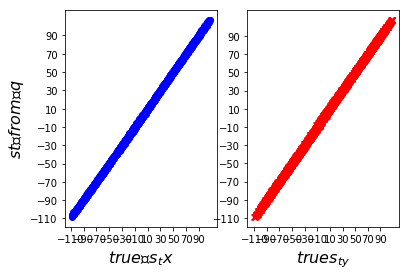

100%|██████████| 24/24 [00:00<00:00, 74.35it/s]

Epoch: 157 Train loss: 12.5591


Test loss: 11.9103


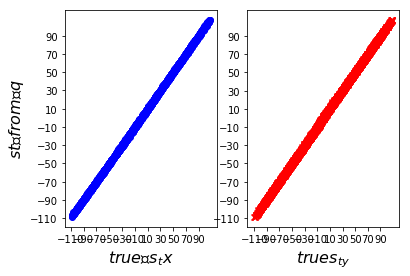

100%|██████████| 24/24 [00:00<00:00, 70.15it/s]

Epoch: 158 Train loss: 12.1762


Test loss: 11.6560


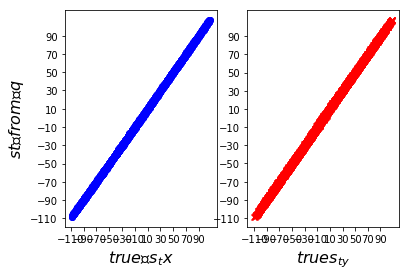

100%|██████████| 24/24 [00:00<00:00, 75.93it/s]

Epoch: 159 Train loss: 11.7675


Test loss: 11.2782


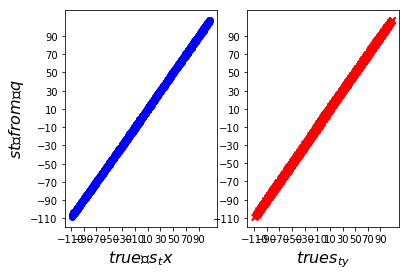

100%|██████████| 24/24 [00:00<00:00, 76.50it/s]

Epoch: 160 Train loss: 11.3843


Test loss: 10.8531


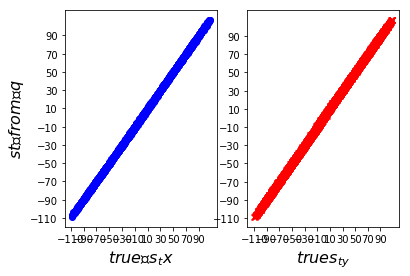

100%|██████████| 24/24 [00:00<00:00, 72.72it/s]

Epoch: 161 Train loss: 11.0252


Test loss: 10.7786


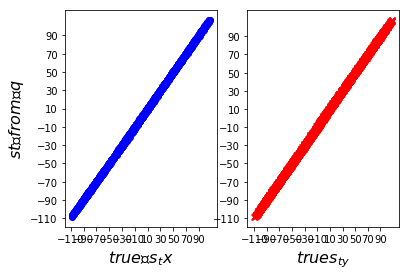

100%|██████████| 24/24 [00:00<00:00, 60.30it/s]

Epoch: 162 Train loss: 10.6238


Test loss: 10.3252


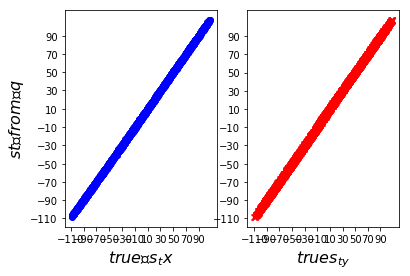

100%|██████████| 24/24 [00:00<00:00, 77.58it/s]

Epoch: 163 Train loss: 10.5667


Test loss: 9.9562


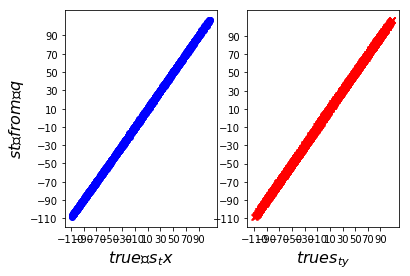

100%|██████████| 24/24 [00:00<00:00, 67.61it/s]

Epoch: 164 Train loss: 10.2665


Test loss: 9.8389


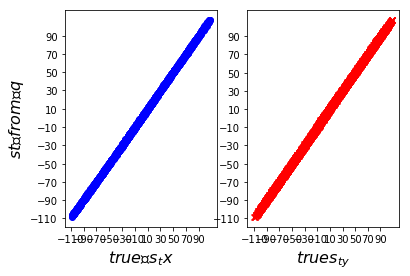

100%|██████████| 24/24 [00:00<00:00, 78.58it/s]


Epoch: 165 Train loss: 10.0167
Test loss: 9.5756


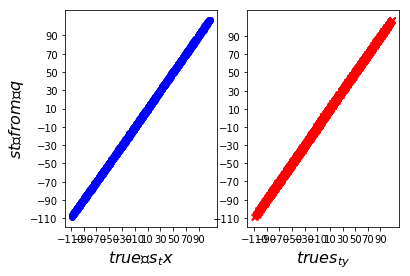

100%|██████████| 24/24 [00:00<00:00, 81.20it/s]

Epoch: 166 Train loss: 9.7712


Test loss: 9.3013


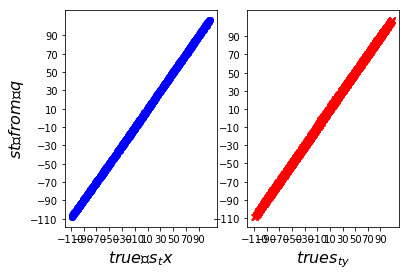

100%|██████████| 24/24 [00:00<00:00, 78.14it/s]

Epoch: 167 Train loss: 9.4610


Test loss: 9.2433


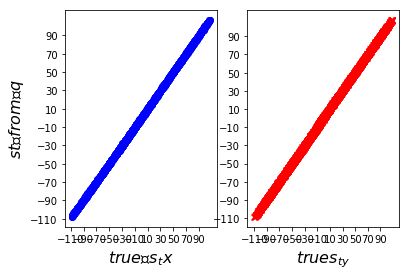

100%|██████████| 24/24 [00:00<00:00, 75.57it/s]

Epoch: 168 Train loss: 9.4067


Test loss: 8.9043


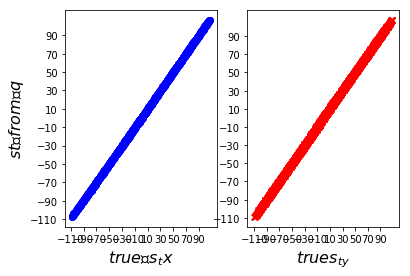

100%|██████████| 24/24 [00:00<00:00, 78.31it/s]


Epoch: 169 Train loss: 9.1381
Test loss: 8.6518


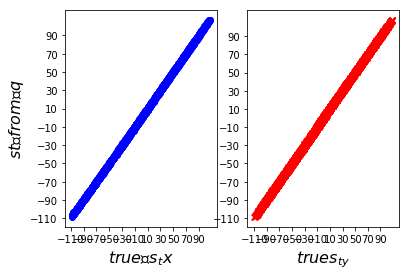

100%|██████████| 24/24 [00:00<00:00, 76.61it/s]

Epoch: 170 Train loss: 8.8035


Test loss: 8.6897


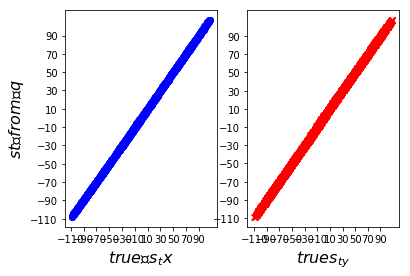

100%|██████████| 24/24 [00:00<00:00, 75.85it/s]

Epoch: 171 Train loss: 8.6206


Test loss: 8.3141


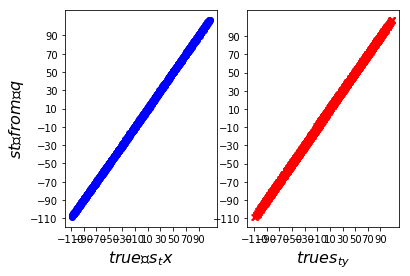

100%|██████████| 24/24 [00:00<00:00, 60.31it/s]

Epoch: 172 Train loss: 8.2853


Test loss: 8.2114


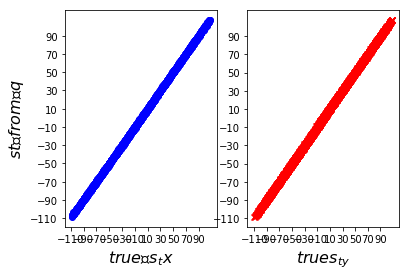

100%|██████████| 24/24 [00:00<00:00, 71.33it/s]

Epoch: 173 Train loss: 8.3942


Test loss: 8.1282


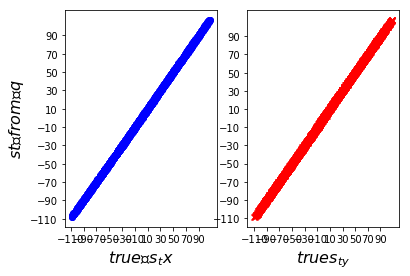

100%|██████████| 24/24 [00:00<00:00, 67.02it/s]

Epoch: 174 Train loss: 8.0574


Test loss: 7.9108


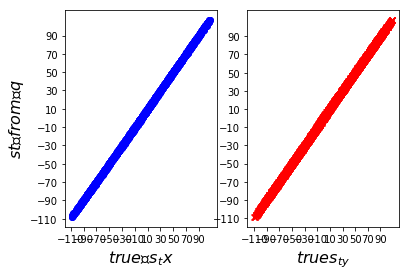

100%|██████████| 24/24 [00:00<00:00, 71.27it/s]

Epoch: 175 Train loss: 7.9901


Test loss: 7.7480


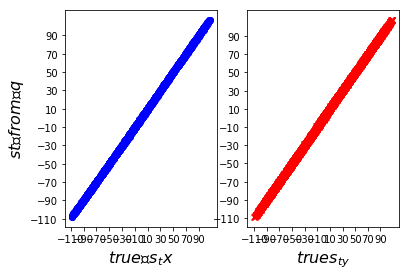

100%|██████████| 24/24 [00:00<00:00, 77.04it/s]

Epoch: 176 Train loss: 7.9316


Test loss: 7.5599


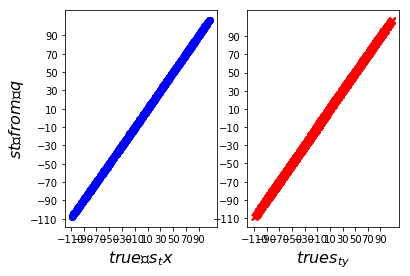

100%|██████████| 24/24 [00:00<00:00, 79.23it/s]


Epoch: 177 Train loss: 7.7081
Test loss: 7.5578


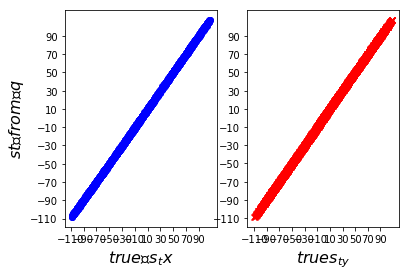

100%|██████████| 24/24 [00:00<00:00, 70.10it/s]

Epoch: 178 Train loss: 7.5046


Test loss: 7.3952


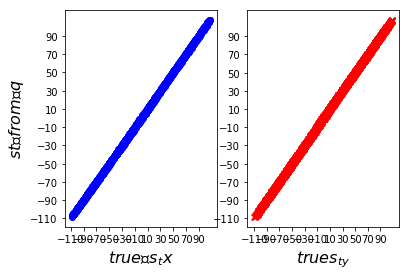

100%|██████████| 24/24 [00:00<00:00, 81.06it/s]

Epoch: 179 Train loss: 7.4178


Test loss: 7.3031


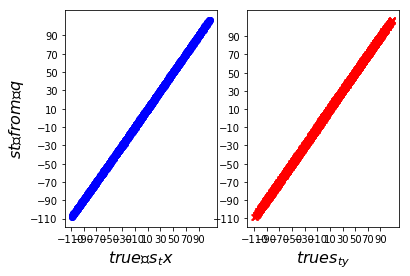

100%|██████████| 24/24 [00:00<00:00, 71.49it/s]

Epoch: 180 Train loss: 7.2214


Test loss: 7.1920


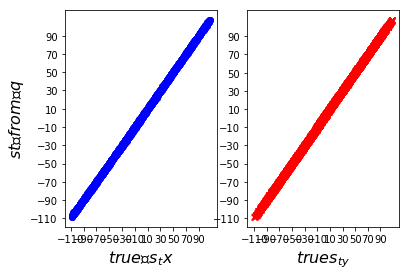

100%|██████████| 24/24 [00:00<00:00, 71.52it/s]

Epoch: 181 Train loss: 7.1083


Test loss: 6.9381


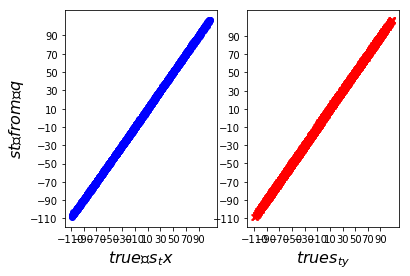

100%|██████████| 24/24 [00:00<00:00, 67.99it/s]

Epoch: 182 Train loss: 7.0177


Test loss: 6.8175


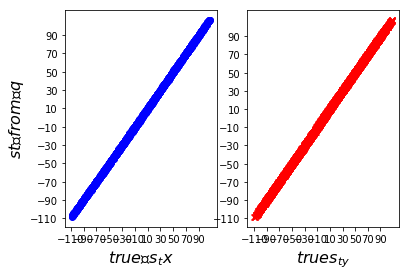

100%|██████████| 24/24 [00:00<00:00, 56.73it/s]

Epoch: 183 Train loss: 6.8242


Test loss: 6.6302


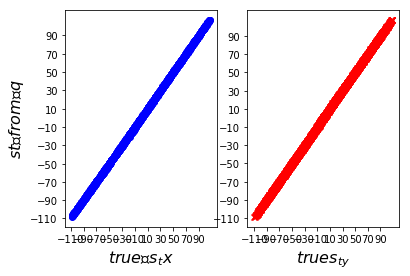

100%|██████████| 24/24 [00:00<00:00, 66.73it/s]

Epoch: 184 Train loss: 6.8957


Test loss: 6.7939


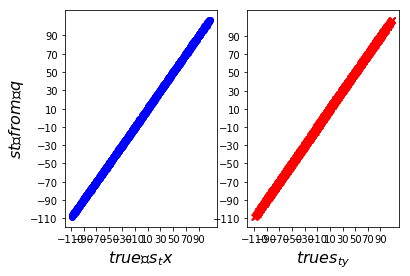

100%|██████████| 24/24 [00:00<00:00, 73.92it/s]

Epoch: 185 Train loss: 6.7642


Test loss: 6.6145


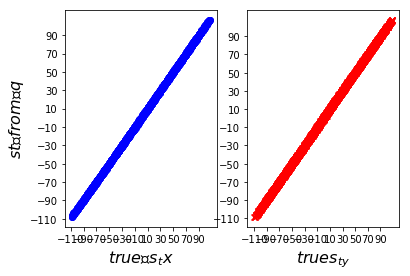

100%|██████████| 24/24 [00:00<00:00, 78.34it/s]

Epoch: 186 Train loss: 6.3968


Test loss: 6.5199


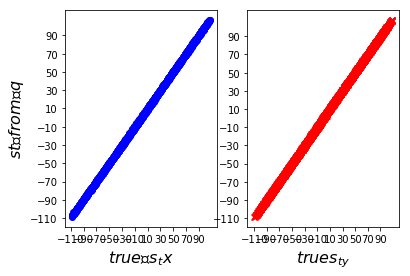

100%|██████████| 24/24 [00:00<00:00, 77.15it/s]

Epoch: 187 Train loss: 6.6220


Test loss: 6.3249


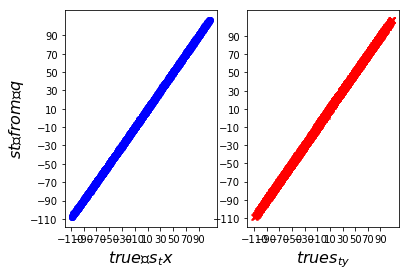

100%|██████████| 24/24 [00:00<00:00, 54.56it/s]

Epoch: 188 Train loss: 6.1667


Test loss: 6.3360


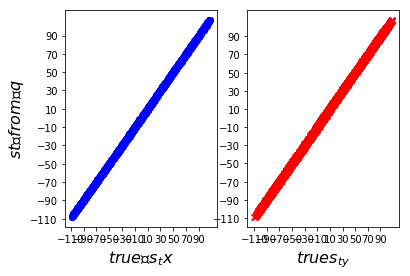

100%|██████████| 24/24 [00:00<00:00, 76.67it/s]

Epoch: 189 Train loss: 6.3610


Test loss: 6.2635


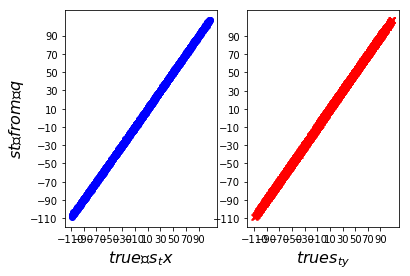

100%|██████████| 24/24 [00:00<00:00, 66.02it/s]

Epoch: 190 Train loss: 6.0977


Test loss: 6.0797


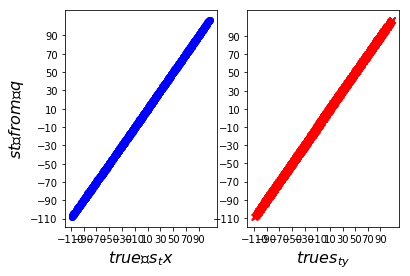

100%|██████████| 24/24 [00:00<00:00, 63.94it/s]

Epoch: 191 Train loss: 6.1033


Test loss: 6.0194


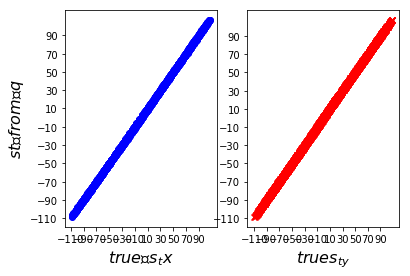

100%|██████████| 24/24 [00:00<00:00, 60.23it/s]

Epoch: 192 Train loss: 5.9302


Test loss: 6.0710


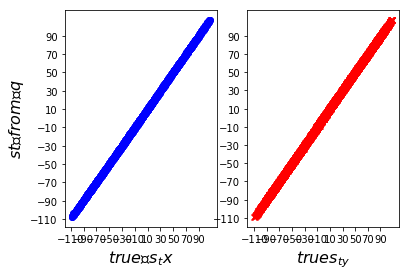

100%|██████████| 24/24 [00:00<00:00, 72.47it/s]

Epoch: 193 Train loss: 5.8926


Test loss: 5.7868


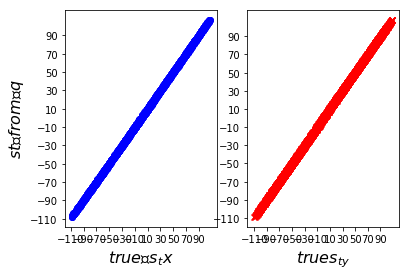

100%|██████████| 24/24 [00:00<00:00, 76.98it/s]

Epoch: 194 Train loss: 5.8709


Test loss: 5.7995


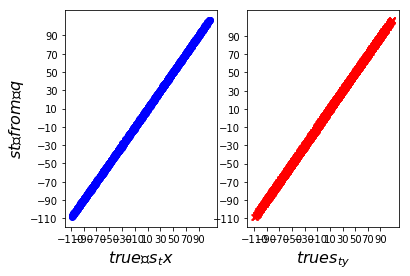

100%|██████████| 24/24 [00:00<00:00, 54.72it/s]

Epoch: 195 Train loss: 5.8997


Test loss: 5.7126


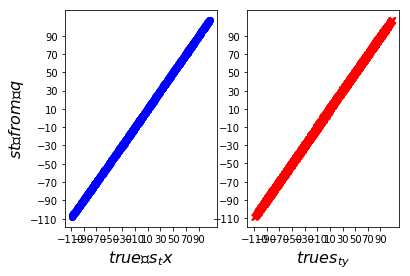

100%|██████████| 24/24 [00:00<00:00, 60.65it/s]

Epoch: 196 Train loss: 5.7079


Test loss: 5.6101


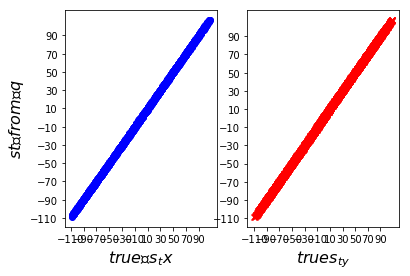

100%|██████████| 24/24 [00:00<00:00, 74.53it/s]

Epoch: 197 Train loss: 5.5167


Test loss: 5.5055


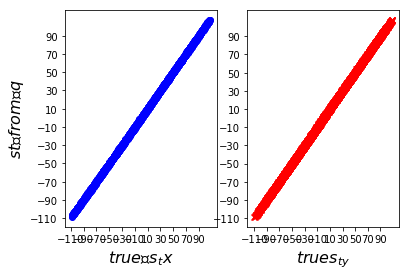

100%|██████████| 24/24 [00:00<00:00, 71.42it/s]

Epoch: 198 Train loss: 5.5648


Test loss: 5.6330


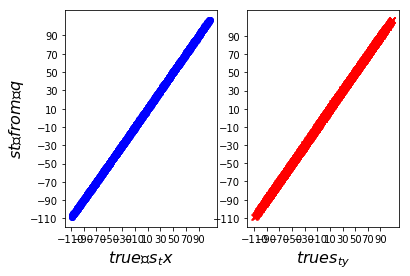

100%|██████████| 24/24 [00:00<00:00, 77.35it/s]

Epoch: 199 Train loss: 5.4181


Test loss: 5.4623


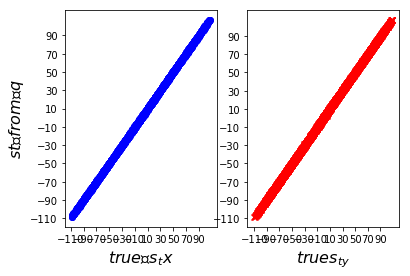

100%|██████████| 24/24 [00:00<00:00, 81.68it/s]

Epoch: 200 Train loss: 5.4113


Test loss: 5.4640


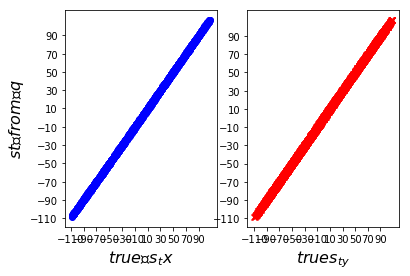

In [43]:
writer = SummaryWriter()

plot_number = 1

s_sample = 0.5 * torch.randn(64, s_dim).to(device)
c_sample = torch.eye(10)[[plot_number]*64].to(device)

# _o, _c = iter(test_loader).next()
# _o = _o.to(device)
# _c = torch.eye(10)[_c].to(device)


for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
#     recon = plot_reconstrunction(_o[:8], _c[:8])
#     sample = plot_image_from_latent(s_sample, c_sample)
#     recon_changing_c = plot_reconstrunction_changing_c(_o[:8], _c[:8])

    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)
    
    #for plot
    history["train_loss"].append(train_loss.item())
    history["test_loss"].append(test_loss.item())

    _s = q.sample({"o": data["o"].to(device), "c": data["c"].to(device),"st1":data["st1"].to(device),"u":data["u"]}, return_all=False)
    plt.subplot(1, 2, 1)
    tru = plt.scatter(data["s"][:,0],_s["s"][:,0],color='blue',marker='o',edgecolors="blue")
    plt.xticks(np.arange(min_data,max_data,grid_inter))
    plt.yticks(np.arange(min_data,max_data,grid_inter))
    plt.ylabel('$st　from　q$', fontsize=16)
    plt.xlabel('$true　s_tx$', fontsize=16)
    
    plt.subplot(1, 2, 2)
    sam = plt.scatter(data["s"][:,1],_s["s"][:,1],color='red',marker='x',edgecolors="red")
    plt.xticks(np.arange(min_data,max_data,grid_inter))
    plt.yticks(np.arange(min_data,max_data,grid_inter))
    plt.xlabel('$true s_{ty}$', fontsize=16)
    ims.append([tru]+[sam])
    
    x = np.linspace(0,100,1)  # xの値域(0, 1, 2, 3)
    y = x               # 直線の式
    plt.plot(x,y,"r-")      # 直線を引く
    plt.show()
    

#     writer.add_image('Image_from_latent', sample, epoch)
#     writer.add_image('Image_reconstrunction', recon, epoch)
#     writer.add_image('Image_reconstrunction_change_c', recon_changing_c, epoch)
    
writer.close()

In [44]:
# #animation
# def iinit():    
#     return (ims[0])
# # animation function: this is called sequentially
# def animate(i):
#   return (ims[i])

# #plot gif
# fig = plt.figure()
# plt.legend(['True','Result'], loc='upper left', fontsize=16)
# ani = animation.ArtistAnimation(fig, ims)
# anim = animation.FuncAnimation(fig, animate, init_func=iinit, frames=epochs, interval=100, blit=True)
# plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
# HTML(ani.to_html5_video())
# rc('animation', html='jshtml')
# anim

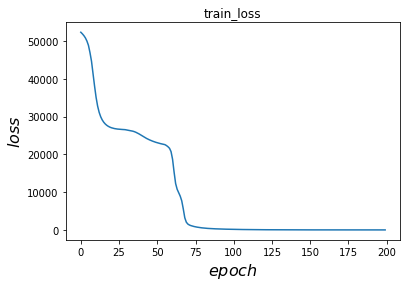

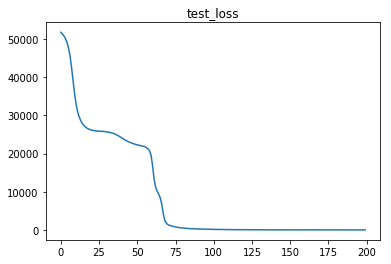

In [45]:
#plot loss    
plt.ylabel('$loss$', fontsize=16)
plt.xlabel('$epoch$', fontsize=16)
plt.title("train_loss")
plt.plot(range(epochs), history["train_loss"])
plt.show()
plt.title("test_loss")
plt.plot(range(epochs), history["test_loss"])
plt.show()

In [65]:
#u_tでの挙動をみるためのテスト
data=unique_datagenerator(sample_num,ssigma,5.0,-5.0)
_s = q.sample({"o": data["o"].to(device), "c": data["c"].to(device),"st1":data["st1"].to(device),"u":data["u"]}, return_all=False)
_o= p.sample({"s": _s["s"].to(device)}, return_all=False)

tensor([[-49.5343, -67.4802],
        [-64.4929,  50.5734],
        [ 68.8004,  32.8039],
        ...,
        [ 32.3105,   2.9636],
        [-83.4235, -97.0594],
        [ -8.2955,  56.3513]])
tensor([[ 5., -5.],
        [ 5., -5.],
        [ 5., -5.],
        ...,
        [ 5., -5.],
        [ 5., -5.],
        [ 5., -5.]])
tensor([[ -44.5343,  -72.4802],
        [ -59.4929,   45.5734],
        [  73.8004,   27.8039],
        ...,
        [  37.3105,   -2.0364],
        [ -78.4235, -102.0594],
        [  -3.2955,   51.3513]])


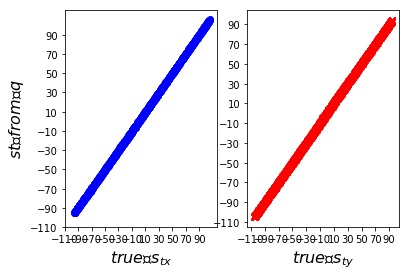

0.43504073717196784
0.45312201568484306


In [66]:
#u_tでの挙動を見るためのテストの描画
plt.subplot(1, 2, 1)
tru = plt.scatter(data["s"][:,0],_s["s"][:,0],color='blue',marker='o',edgecolors="blue")
plt.xticks(np.arange(min_data,max_data,grid_inter))
plt.yticks(np.arange(min_data,max_data,grid_inter))
plt.ylabel('$st　from　q$', fontsize=16)
plt.xlabel('$true　s_{tx}$', fontsize=16)

plt.subplot(1, 2, 2)
sam = plt.scatter(data["s"][:,1],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xticks(np.arange(min_data,max_data,grid_inter))
plt.yticks(np.arange(min_data,max_data,grid_inter))
plt.xlabel('$true　s_{ty}$', fontsize=16)
ims.append([tru]+[sam])
plt.grid(which='minor',color='black',linestyle='-')
plt.show()

lossx=0
lossy=0
_ss=_s["s"]
for i in range(0,sample_num-1,1):
    lossx+=np.abs(data["s"][i][0].numpy()-_ss[i][0].numpy())
    lossy+=np.abs(data["s"][i][1].numpy()-_ss[i][1].numpy())
print(lossx/sample_num)
print(lossy/sample_num)

In [48]:
print(data["s"][:,0])
print(_ss[:,0])

tensor([-29.4792, -92.3623, -90.7463,  ...,  36.4168, -92.1557, 100.7082])
tensor([-29.6529, -92.4887, -91.8484,  ...,  35.7746, -92.4674, 101.2475])


{'s': tensor([[-29.6529, -64.4200],
        [-92.4887,  63.8535],
        [-91.8484,  39.8261],
        ...,
        [ 35.7746,  49.6181],
        [-92.4674,  10.4063],
        [101.2475,   9.0360]])}
tensor([[-29.5196, -64.6857],
        [-93.1117,  64.3972],
        [-91.9904,  39.9968],
        ...,
        [ 36.3300,  49.7177],
        [-92.1858,   9.4496],
        [101.3427,   7.9403]])
tensor([[-29.4792, -64.6264],
        [-92.3623,  64.3080],
        [-90.7463,  40.4446],
        ...,
        [ 36.4168,  49.3069],
        [-92.1557,  10.5451],
        [100.7082,   8.4353]])


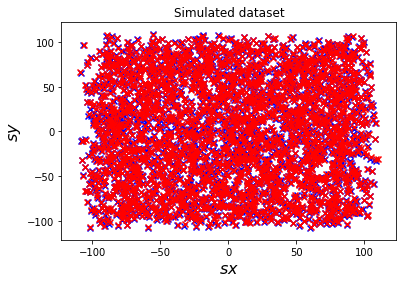

In [49]:
print(_s)
print(_o["o"])
print(data["s"])

# plt.scatter(sample_o[:,0],sample_o[:,1],color='blue',marker='o',edgecolors="blue")
plt.scatter(data["o"][:,0],data["o"][:,1],color='blue',marker='x',edgecolors="red")
plt.scatter(_o["o"][:,0],_o["o"][:,1],color='red',marker='x',edgecolors="red")
plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")
plt.show()

In [50]:
loss=0
_ss=_s["s"]
for i in range(0,sample_num-1,1):
    loss+=np.abs(data["s"][i].numpy()-_ss[i])
print(loss/sample_num)

TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, Number alpha)
 * (Tensor input, Number other, Number alpha)


In [ ]:
max_data=10#max_data
min_data=-4#min_data
grid_inter=1

plot_data=test_data

_s = q.sample({"o": plot_data["o"].to(device), "c": plot_data["c"].to(device)}, return_all=False)

#show sample points
plt.scatter(plot_data["s"][:,0],plot_data["s"][:,1],color='blue',marker='o',edgecolors="blue")
plt.scatter(_s["s"][:,0],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")
plt.show()

plt.subplot(1, 2, 1)
plt.scatter(plot_data["s"][:,0],plot_data["s"][:,1],color='blue',marker='o',edgecolors="blue")
plt.xticks(np.arange(min_data-1,max_data+1,grid_inter))
plt.subplot(1,2,2)
plt.scatter(_s["s"][:,0],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xticks(np.arange(min_data-1,max_data+1,grid_inter))
plt.show()
